# 이상 탐지 프로젝트
## 0. 데이터 준비

In [53]:
#!pip install optuna
#!pip install catboost

In [43]:
import os
from pprint import pprint

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA

from sklearn.utils.class_weight import compute_class_weight
import optuna
from optuna import Trial
from optuna.samplers import TPESampler

from catboost import CatBoostClassifier

import scipy.cluster.hierarchy as sch


In [100]:
ROOT_DIR = "data"
RANDOM_STATE = 110

# Load data
train_data = pd.read_csv(os.path.join(ROOT_DIR, "train.csv"))

In [101]:
# 설정을 변경하여 모든 열을 표시하도록 설정
pd.set_option('display.max_columns', None)

train_data

Wip Line_Dam Process Desc._Dam     Equipment_Dam Model.Suffix_Dam  \
0          IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334505   
1          IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334505   
2          IVI-OB6     Dam Dispenser  Dam dispenser #2      AJX75334501   
3          IVI-OB6     Dam Dispenser  Dam dispenser #2      AJX75334501   
4          IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334501   
...            ...               ...               ...              ...   
40501      IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334501   
40502      IVI-OB6     Dam Dispenser  Dam dispenser #2      AJX75334501   
40503      IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334501   
40504      IVI-OB6     Dam Dispenser  Dam dispenser #2      AJX75334501   
40505      IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334501   

      Workorder_Dam  Insp. Seq No._Dam Insp Judge Code_Dam  \
0        4F1XA938-1                  1                  OK   
1        3KPM0016-2                  1                  OK   
2        4E1X9167-1                  1                  OK   
3        3K1X0057-1                  1                  OK   
4        3HPM0007-1                  1                  OK   
...             ...                ...                 ...   
40501    3J1XF434-2                  1                  OK   
40502    4E1XC796-1                  1                  OK   
40503    4C1XD438-1                  1                  OK   
40504    3I1XA258-1                  1                  OK   
40505    3G1XA501-1                  1                  OK   

       CURE END POSITION X Collect Result_Dam  \
0                                       240.0   
1                                       240.0   
2                                      1000.0   
3                                      1000.0   
4                                       240.0   
...                                       ...   
40501                                   240.0   
40502                                  1000.0   
40503                                   240.0   
40504                                  1000.0   
40505                                   240.0   

       CURE END POSITION X Unit Time_Dam  CURE END POSITION X Judge Value_Dam  \
0                                    NaN                                  NaN   
1                                    NaN                                  NaN   
2                                    NaN                                  NaN   
3                                    NaN                                  NaN   
4                                    NaN                                  NaN   
...                                  ...                                  ...   
40501                                NaN                                  NaN   
40502                                NaN                                  NaN   
40503                                NaN                                  NaN   
40504                                NaN                                  NaN   
40505                                NaN                                  NaN   

       CURE END POSITION Z Collect Result_Dam  \
0                                         2.5   
1                                         2.5   
2                                        12.5   
3                                        12.5   
4                                         2.5   
...                                       ...   
40501                                     2.5   
40502                                    12.5   
40503                                     2.5   
40504                                    12.5   
40505                                     2.5   

       CURE END POSITION Z Unit Time_Dam  CURE END POSITION Z Judge Value_Dam  \
0                                    NaN                                  NaN   
1                                    NaN       

## 2. 데이터 전처리

In [102]:
def preprocess_data(df):
    # 데이터 오류 수정
    ## 'OK' 값을 결측치로 변환할 열들
    columns_to_replace = [
        'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2',
        'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1',
        'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'
    ]
    ## 각 열에 대해 'OK' 값을 결측치로 변환
    df[columns_to_replace] = df[columns_to_replace].replace('OK', pd.NA)
    ## 수치형으로 변환
    df[columns_to_replace] = df[columns_to_replace].apply(pd.to_numeric)
    
    
    # 결측치 처리
    ## 모든 행이 다 결측치인 열을 제거
    df = df.loc[:, ~df.isnull().all()]
    
    ## is_null 파생변수 생성
    ###결측치라면 1, 아니면 0
    df['is_null'] = df['HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam'].isnull().astype(int) 
    
    ## 각 열의 결측치 개수를 계산
    missing_values = df.isnull().sum()
    
    ## 결측치가 있는 열들만 필터링
    missing_columns = missing_values[missing_values > 0]
    
    ## 결측치가 있는 칼럼을 제외한 새로운 데이터프레임 생성
    columns_to_drop = missing_columns.index
    df = df.drop(columns=columns_to_drop)
    
    ## 결측치 없고, 유니크한 값 1개 피처 찾아서 제거
    train_na_columns = [col for col in df.columns if df[col].isna().sum() == 0 and df[col].nunique() == 1]
    df = df.drop(columns=train_na_columns)
    
    
    # 컬럼 통일 및 제거
    ## WorkMode 데이터에서 Fill 1과 Fill 2가 유사해서 조정 후 하나 드랍
    df['WorkMode Collect Result_Dam'] = df['WorkMode Collect Result_Dam'].replace(7, np.nan).astype(object)
    df['WorkMode Collect Result_Fill2'] = df['WorkMode Collect Result_Fill2'].replace(0, 7).astype(object)
    df.drop(columns=['WorkMode Collect Result_Fill1'], inplace=True)
    
    ## 총 시간 변수 생성 및 개별 변수 제거
    df['Total time'] = (df['Machine Tact time Collect Result_Dam'] +
                        df['Machine Tact time Collect Result_Fill1'] +
                        df['Machine Tact time Collect Result_Fill2'])
    df.drop(columns=['Machine Tact time Collect Result_Dam', 
                     'Machine Tact time Collect Result_Fill1', 
                     'Machine Tact time Collect Result_Fill2'], inplace=True)
    
    # 두께 데이터 (일단) drop & 동일 칼럼 제거
    df.drop(columns=['THICKNESS 1 Collect Result_Dam', 
                     'THICKNESS 2 Collect Result_Dam', 
                     'THICKNESS 3 Collect Result_Dam',
                    'Stage1 Circle3 Distance Speed Collect Result_Dam', 'Stage1 Circle4 Distance Speed Collect Result_Dam', 
                     'Stage2 Circle3 Distance Speed Collect Result_Dam', 'Stage2 Circle4 Distance Speed Collect Result_Dam', 
                     'Stage3 Circle3 Distance Speed Collect Result_Dam', 'Stage3 Circle4 Distance Speed Collect Result_Dam',
                     'Stage1 Line3 Distance Speed Collect Result_Dam', 'Stage2 Line3 Distance Speed Collect Result_Dam', 
                     'Stage3 Line3 Distance Speed Collect Result_Dam','Model.Suffix_AutoClave', 'Model.Suffix_Fill1', 'Model.Suffix_Fill2',
                     'Workorder_AutoClave', 'Workorder_Fill1', 'Workorder_Fill2',], inplace=True)
    
    
    # 장비 관련 파생변수 
    ## 'equipment'가 들어가는 칼럼을 찾기
    equipment_columns = [col for col in df.columns if 'Equipment' in col]
    
    ## 각 'equipment' 열에 대해 마지막 숫자를 기준으로 라벨 인코딩 수행
    for col in equipment_columns:
        # 마지막 숫자를 추출
        df[col + '_last_digit'] = df[col].str.extract(r'(\d)$')
        # _last_digit 칼럼을 숫자형으로 변환
        df[col + '_last_digit'] = df[col + '_last_digit'].astype(float)
    
    ## 'Equipment'가 들어가는 칼럼 drop
    df = df.drop(columns=equipment_columns)
    
    # Chamber Temp. Judge Value_AutoClave 칼럼 값 변환
    df['Chamber Temp. Judge Value_AutoClave'] = df['Chamber Temp. Judge Value_AutoClave'].apply(lambda x: 1 if x == 'OK' else 0)

    return df

### 파생변수 추가

In [103]:
def filter_coordinate_columns(df):
    # 좌표 데이터들만 필터링
    coordinate_columns = df.filter(regex='X|Y|Z').columns
    coordinate_data = df[coordinate_columns]

    # 결측치가 있는 행 제거
    coordinate_data_clean = coordinate_data.dropna()

    # 결측치 제거 후 상관계수 행렬 계산
    correlation_matrix_clean = coordinate_data_clean.corr()

    # 상관계수 절대값이 1인 경우 필터링 (자기 자신과의 상관관계 제외)
    threshold = 1
    high_correlation_pairs = correlation_matrix_clean[
        (correlation_matrix_clean.abs() >= threshold) & (correlation_matrix_clean.abs() < 1)
    ]

    # 상관계수가 1인 변수 쌍 확인 및 저장
    high_corr_columns = set()  # 상관관계가 1인 칼럼들을 저장할 집합
    for i in range(len(correlation_matrix_clean.columns)):
        for j in range(i+1, len(correlation_matrix_clean.columns)):
            if abs(correlation_matrix_clean.iloc[i, j]) >= threshold:
                col1 = correlation_matrix_clean.columns[i]
                col2 = correlation_matrix_clean.columns[j]
                high_corr_columns.update([col1, col2])

    # 상관관계가 높은 칼럼들을 저장할 딕셔너리 초기화
    correlation_groups = defaultdict(set)

    # 상관계수가 threshold 이상인 변수 쌍을 그룹화
    for i in range(len(high_correlation_pairs)):
        for j in range(i+1, len(high_correlation_pairs.columns)):
            if abs(correlation_matrix_clean.iloc[i, j]) >= threshold:
                col1 = correlation_matrix_clean.columns[i]
                col2 = correlation_matrix_clean.columns[j]
                # 그룹화된 변수들을 같은 그룹에 추가
                for group in correlation_groups.values():
                    if col1 in group or col2 in group:
                        group.update([col1, col2])
                        break
                else:
                    # 새로운 그룹 생성
                    correlation_groups[len(correlation_groups)] = {col1, col2}

    # correlation_groups에 포함된 모든 칼럼들 집합으로 수집
    excluded_columns = set()
    for group in correlation_groups.values():
        excluded_columns.update(group)

    # 제외된 좌표 칼럼들만 필터링
    filtered_coordinate_data = coordinate_data.drop(columns=excluded_columns, errors='ignore')

    # PCA에 사용할 칼럼명 추출
    filtered_coordinate_cols = filtered_coordinate_data.columns

    return filtered_coordinate_cols, correlation_groups

In [104]:
train_data = preprocess_data(train_data)

In [105]:
filtered_cols, corr_groups = filter_coordinate_columns(train_data)

# 결과 확인
print("Filtered Coordinate Columns:")
print(filtered_cols)

Filtered Coordinate Columns:
Index(['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam',
       'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam',
       'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam',
       'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam',
       'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam',
       'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam',
       'HEAD Standby Position X Collect Result_Dam',
       'Head Clean Position Z Collect Result_Dam',
       'Head Purge Position X Collect Result_Dam',
       'Head Purge Position Z Collect Result_Dam',
       'Head Zero Position Y Collect Result_Dam',
       'Head Zero Position Z Collect Result_Dam',
       'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1',
       'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1',
       'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1',
       'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Re

In [106]:
# corr_groups에 저장된 칼럼들을 하나의 리스트로 담기
all_columns = []
seen_columns = set()

for group in corr_groups.values():
    for col in group:
        if col not in seen_columns:
            all_columns.append(col)
            seen_columns.add(col)

# 결과 확인
print(all_columns)

['CURE END POSITION X Collect Result_Dam', 'CURE END POSITION Z Collect Result_Dam', 'CURE START POSITION X Collect Result_Dam', 'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam', 'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam', 'Head Clean Position X Collect Result_Fill2', 'Head Purge Position X Collect Result_Fill2', 'Head Clean Position Y Collect Result_Dam', 'Head Zero Position X Collect Result_Dam', 'HEAD Standby Position Z Collect Result_Fill1', 'HEAD Standby Position Y Collect Result_Fill1', 'Head Purge Position Y Collect Result_Fill1', 'HEAD Standby Position Z Collect Result_Dam', 'Head Clean Position Z Collect Result_Fill1', 'Head Clean Position Y Collect Result_Fill2', 'Head Purge Position Z Collect Result_Fill2', 'HEAD Standby Position Z Collect Result_Fill2', 'Head Purge Position Y Collect Result_Fill2', 'HEAD Standby Position Y Collect Result_Fill2', 'Head Clean Position X Collect Result_Fill1', 'Head Purge Position X Collect Result_Fill1', 'Head Clean 

In [107]:
def apply_pca(df, filtered_coordinate_cols, n_components, prefix):
    # PCA에 사용할 데이터셋 추출
    pca_input_data = df[filtered_coordinate_cols]

    # PCA 수행
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(pca_input_data)

    # PCA 결과를 데이터프레임으로 저장
    pca_df = pd.DataFrame(data=pca_result, columns=[f'{prefix}{i+1}' for i in range(n_components)])

    # PCA에 사용된 좌표 피처 제거
    df = df.drop(columns=filtered_coordinate_cols)

    # PCA 결과 (주성분) 추가
    for i in range(n_components):
        df[f'{prefix}{i+1}'] = pca_df[f'{prefix}{i+1}']

    return df, pca

In [108]:
train_data, pca_result_PC = apply_pca(train_data, filtered_cols, 2, 'PC')
train_data

Model.Suffix_Dam Workorder_Dam  CURE END POSITION X Collect Result_Dam  \
0          AJX75334505    4F1XA938-1                                   240.0   
1          AJX75334505    3KPM0016-2                                   240.0   
2          AJX75334501    4E1X9167-1                                  1000.0   
3          AJX75334501    3K1X0057-1                                  1000.0   
4          AJX75334501    3HPM0007-1                                   240.0   
...                ...           ...                                     ...   
40501      AJX75334501    3J1XF434-2                                   240.0   
40502      AJX75334501    4E1XC796-1                                  1000.0   
40503      AJX75334501    4C1XD438-1                                   240.0   
40504      AJX75334501    3I1XA258-1                                  1000.0   
40505      AJX75334501    3G1XA501-1                                   240.0   

       CURE END POSITION Z Collect Result_Dam  \
0                                         2.5   
1                                         2.5   
2                                        12.5   
3                                        12.5   
4                                         2.5   
...                                       ...   
40501                                     2.5   
40502                                    12.5   
40503                                     2.5   
40504                                    12.5   
40505                                     2.5   

       CURE END POSITION Θ Collect Result_Dam  CURE SPEED Collect Result_Dam  \
0                                         -90                            100   
1                                         -90                             70   
2                                          90                             85   
3                                          90                             70   
4                                         -90                             70   
...                                       ...                            ...   
40501                                     -90                             70   
40502                                      90                            100   
40503                                     -90                            100   
40504                                      90                             70   
40505                                     -90                             70   

       CURE START POSITION X Collect Result_Dam  \
0                                          1030   
1                                          1030   
2                                           280   
3                                           280   
4                                          1030   
...                                         ...   
40501                                      1030   
40502                                       280   
40503                                      1030   
40504                                       280   
40505                                      1030   

       CURE START POSITION Θ Collect Result_Dam  \
0                                           -90   
1                                           -90   
2                                            90   
3                                            90   
4                                           -90   
...                                         ...   
40501                                       -90   
40502                                        90   
40503                                       -90   
40504                                        90   
40505                                       -90   

       DISCHARGED SPEED OF RESIN Collect Result_Dam  \
0                                                16   
1                                                10   
2                                                16   
3                                                

In [109]:
train_data, pca_result_corr_PC = apply_pca(train_data, all_columns, 2,  prefix='corr_PC')
train_data

Model.Suffix_Dam Workorder_Dam  CURE END POSITION Θ Collect Result_Dam  \
0          AJX75334505    4F1XA938-1                                     -90   
1          AJX75334505    3KPM0016-2                                     -90   
2          AJX75334501    4E1X9167-1                                      90   
3          AJX75334501    3K1X0057-1                                      90   
4          AJX75334501    3HPM0007-1                                     -90   
...                ...           ...                                     ...   
40501      AJX75334501    3J1XF434-2                                     -90   
40502      AJX75334501    4E1XC796-1                                      90   
40503      AJX75334501    4C1XD438-1                                     -90   
40504      AJX75334501    3I1XA258-1                                      90   
40505      AJX75334501    3G1XA501-1                                     -90   

       CURE SPEED Collect Result_Dam  \
0                                100   
1                                 70   
2                                 85   
3                                 70   
4                                 70   
...                              ...   
40501                             70   
40502                            100   
40503                            100   
40504                             70   
40505                             70   

       CURE START POSITION Θ Collect Result_Dam  \
0                                           -90   
1                                           -90   
2                                            90   
3                                            90   
4                                           -90   
...                                         ...   
40501                                       -90   
40502                                        90   
40503                                       -90   
40504                                        90   
40505                                       -90   

       DISCHARGED SPEED OF RESIN Collect Result_Dam  \
0                                                16   
1                                                10   
2                                                16   
3                                                10   
4                                                10   
...                                             ...   
40501                                            10   
40502                                            16   
40503                                            16   
40504                                            10   
40505                                            10   

       DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam  \
0                                                   14.9     
1                                                   21.3     
2                                                   14.7     
3                                                   21.3     
4                                                    9.7     
...                                                  ...     
40501                                               17.0     
40502                                               14.9     
40503                                               14.2     
40504                                                9.7     
40505                                                9.6     

       DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam  \
0                                                    8.4     
1                                                    4.9     
2                                                    8.5     
3                                                    8.4     
4                                                    4.9     
...                                                  ...     
40501                                                5.0     
40502                                            

## 2. EDA

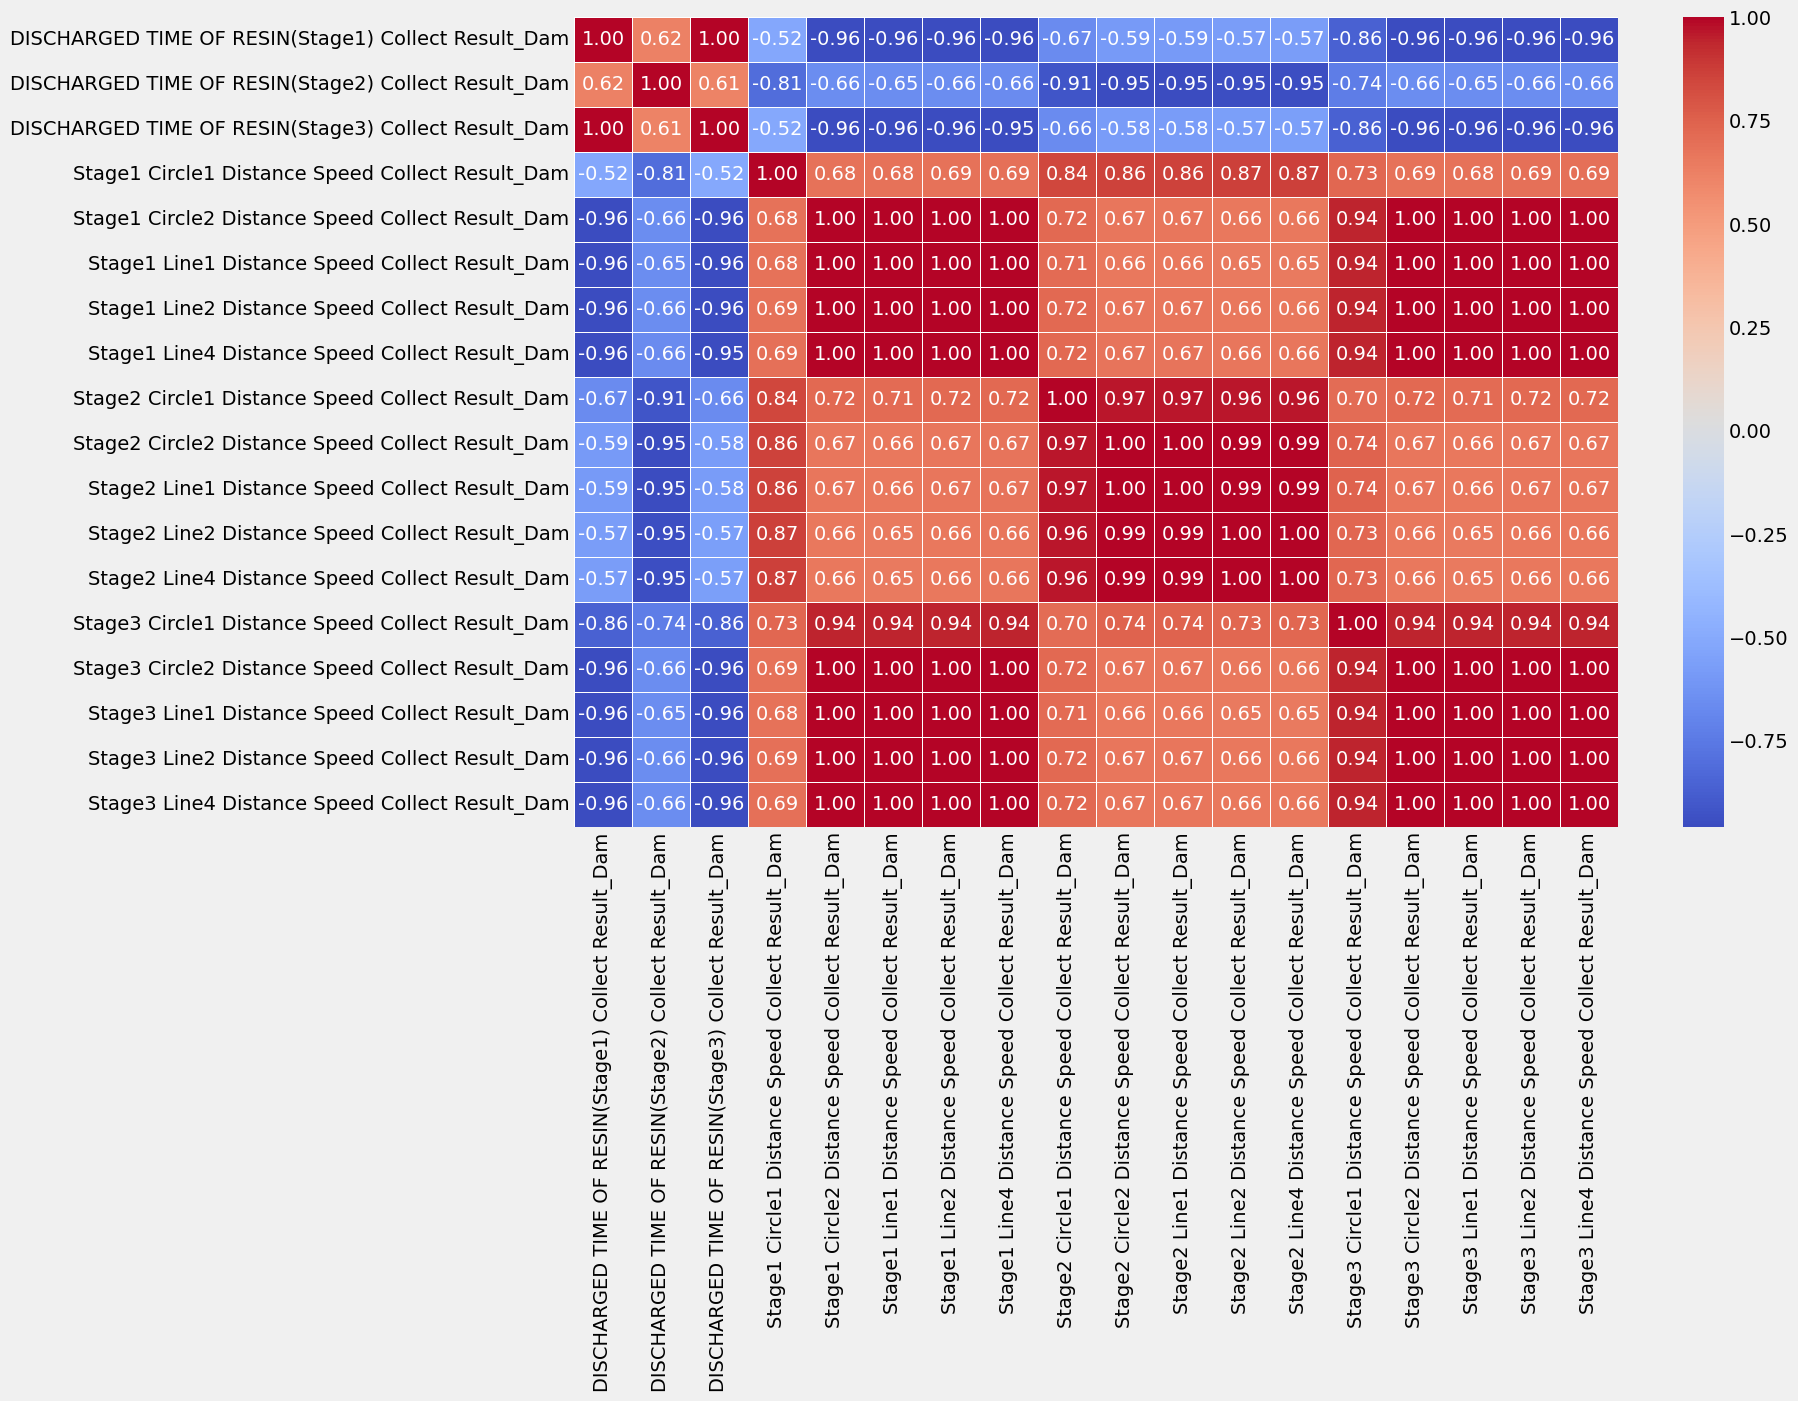

In [110]:
# 관심 있는 두 그룹의 칼럼들을 리스트로 정의
group1_columns = [
    'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam',
    'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam',
    'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam'
]

group2_columns = [
    'Stage1 Circle1 Distance Speed Collect Result_Dam',
    'Stage1 Circle2 Distance Speed Collect Result_Dam',
    'Stage1 Line1 Distance Speed Collect Result_Dam',
    'Stage1 Line2 Distance Speed Collect Result_Dam',
    'Stage1 Line4 Distance Speed Collect Result_Dam',
    'Stage2 Circle1 Distance Speed Collect Result_Dam',
    'Stage2 Circle2 Distance Speed Collect Result_Dam',
    'Stage2 Line1 Distance Speed Collect Result_Dam',
    'Stage2 Line2 Distance Speed Collect Result_Dam',
    'Stage2 Line4 Distance Speed Collect Result_Dam',
    'Stage3 Circle1 Distance Speed Collect Result_Dam',
    'Stage3 Circle2 Distance Speed Collect Result_Dam',
    'Stage3 Line1 Distance Speed Collect Result_Dam',
    'Stage3 Line2 Distance Speed Collect Result_Dam',
    'Stage3 Line4 Distance Speed Collect Result_Dam'
]

# 두 그룹의 칼럼들을 합쳐서 필터링
selected_columns = group1_columns + group2_columns
selected_data = train_data[selected_columns]

# 상관관계 행렬 계산
correlation_matrix = selected_data.corr()

# 히트맵으로 상관관계 행렬 시각화
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.show()

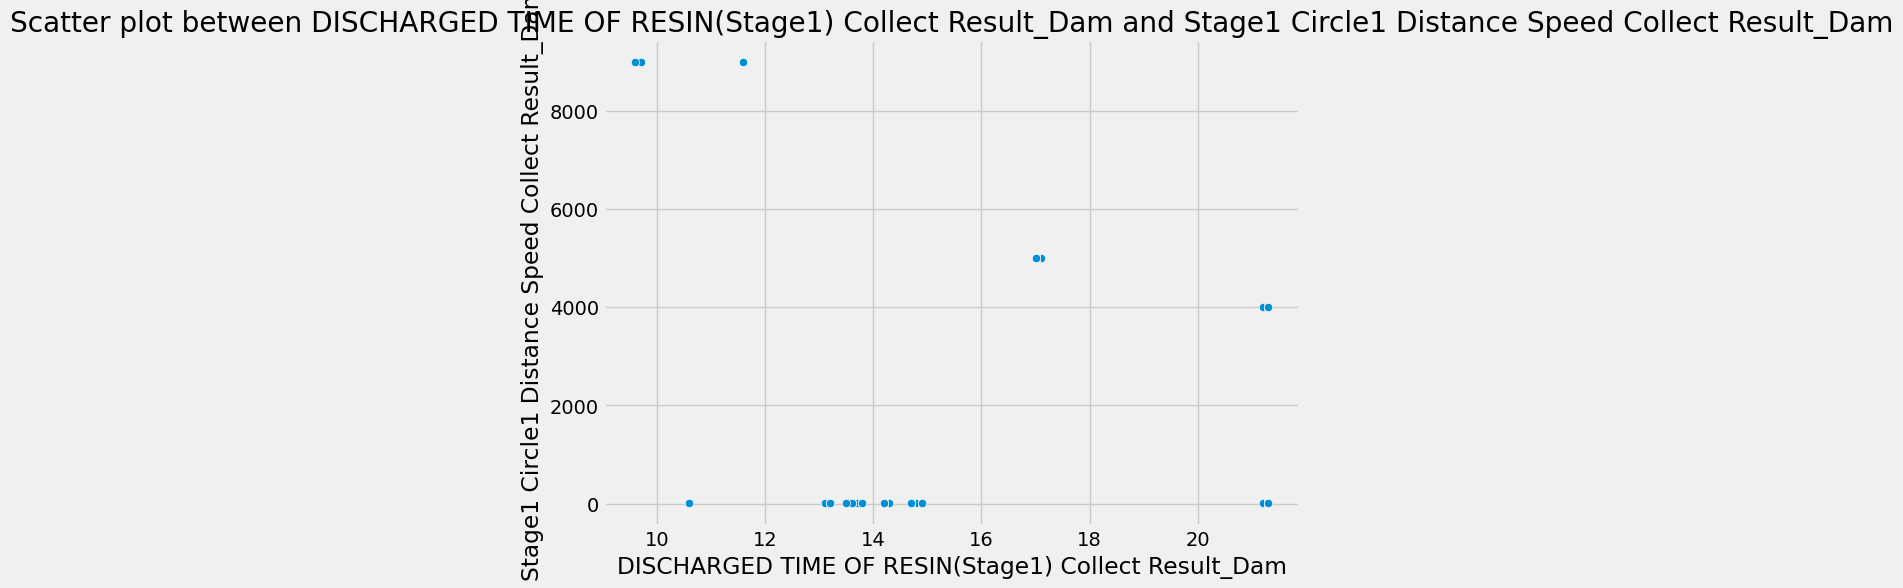

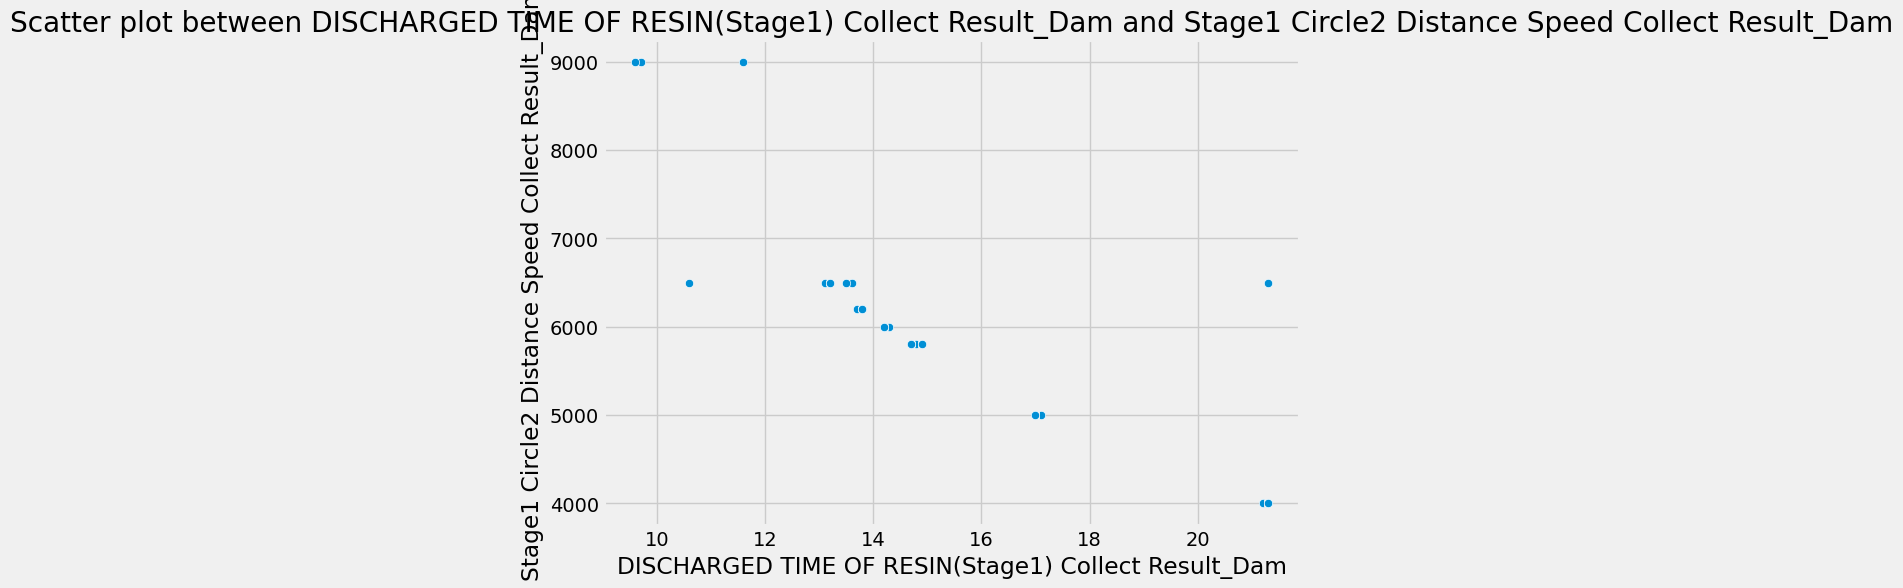

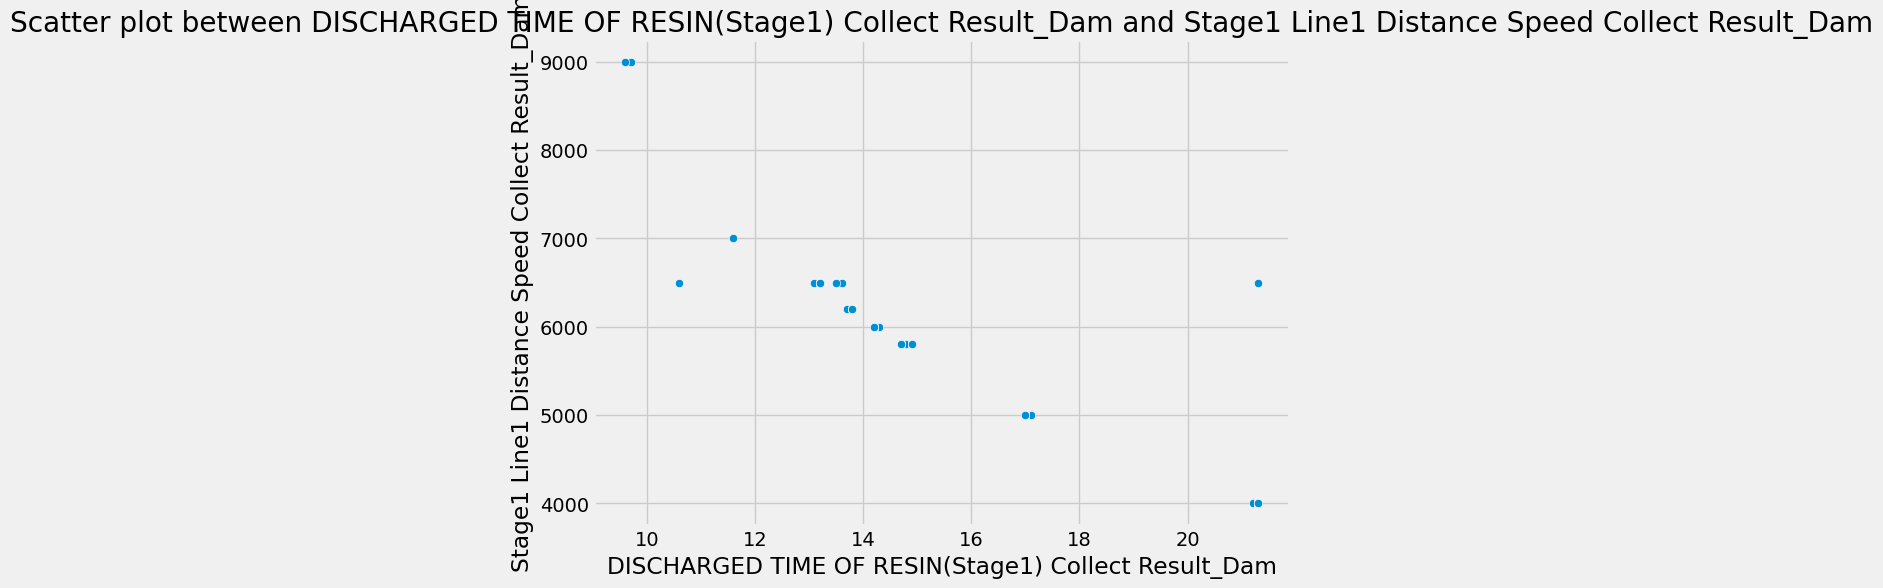

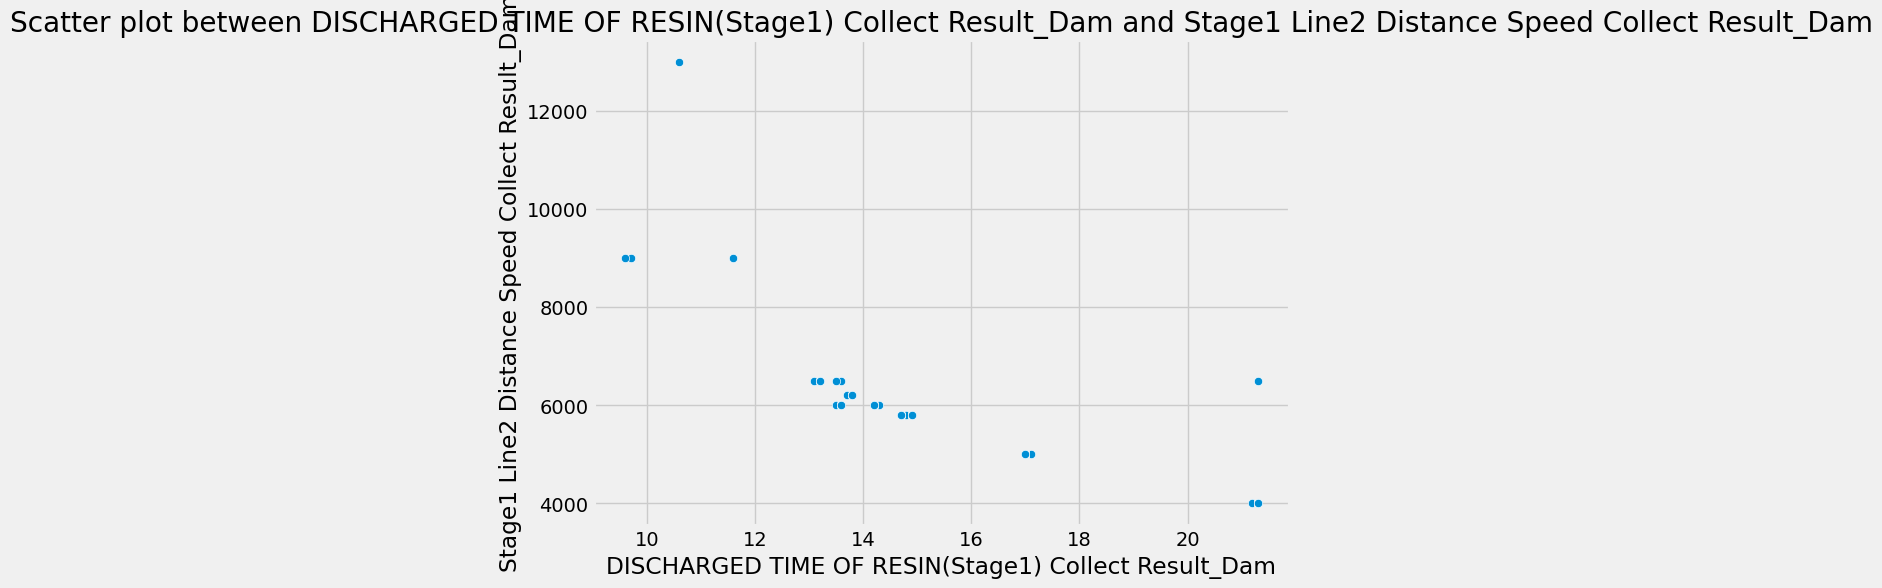

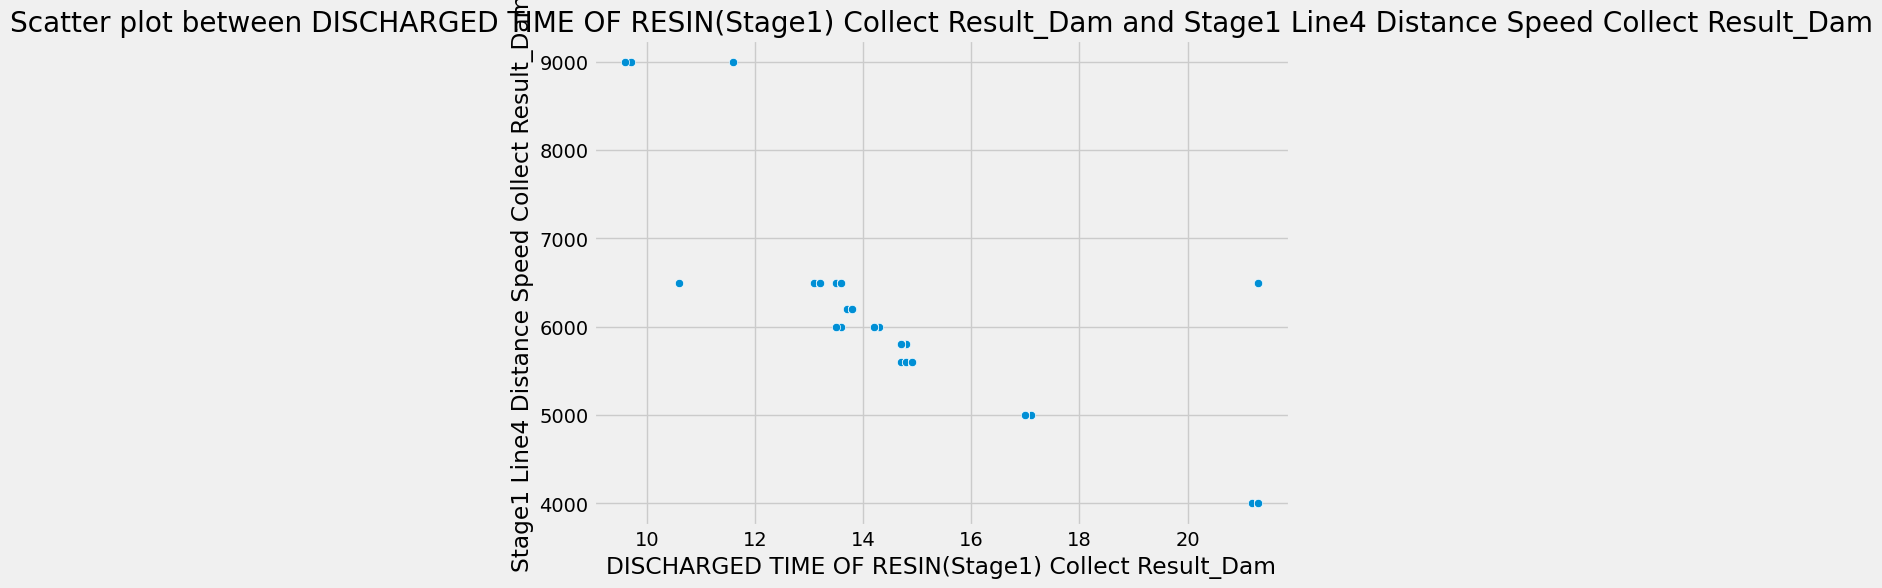

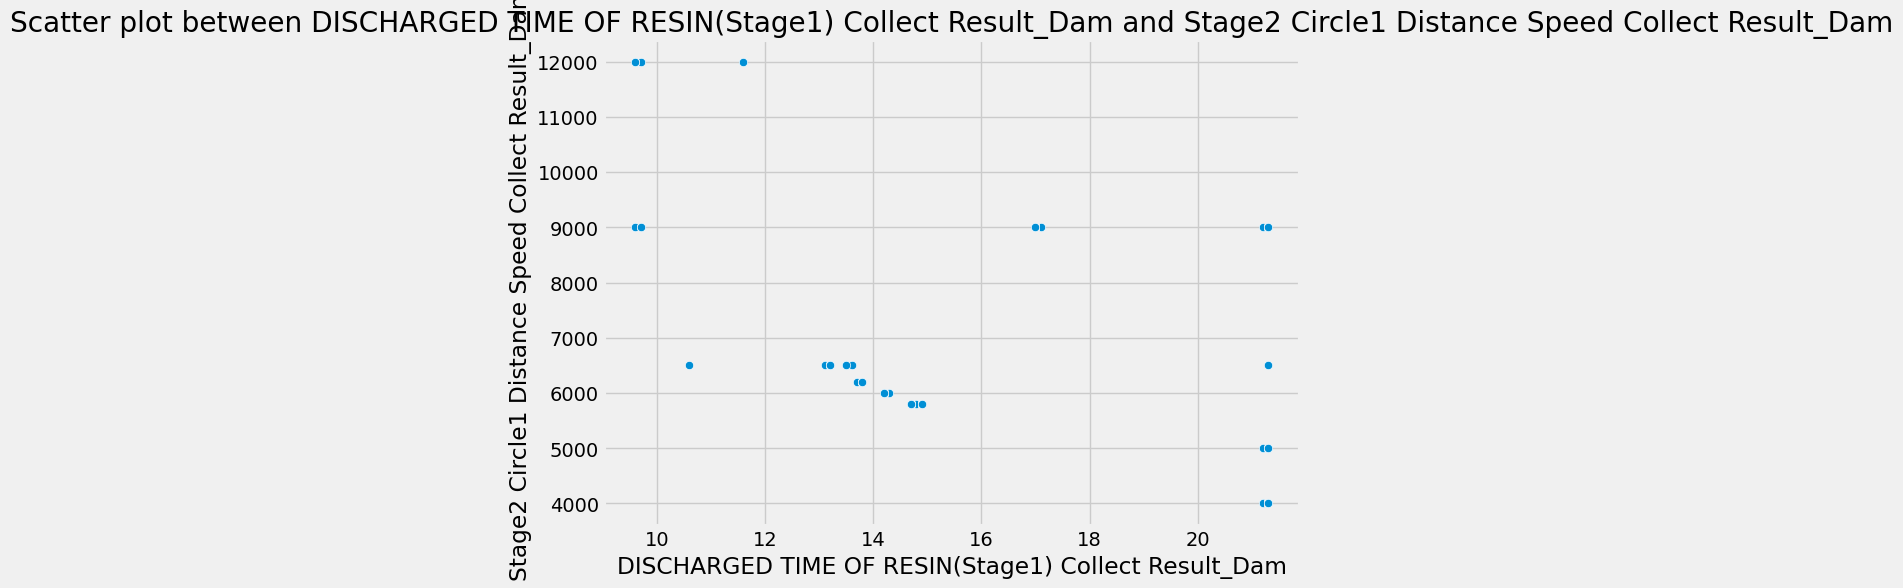

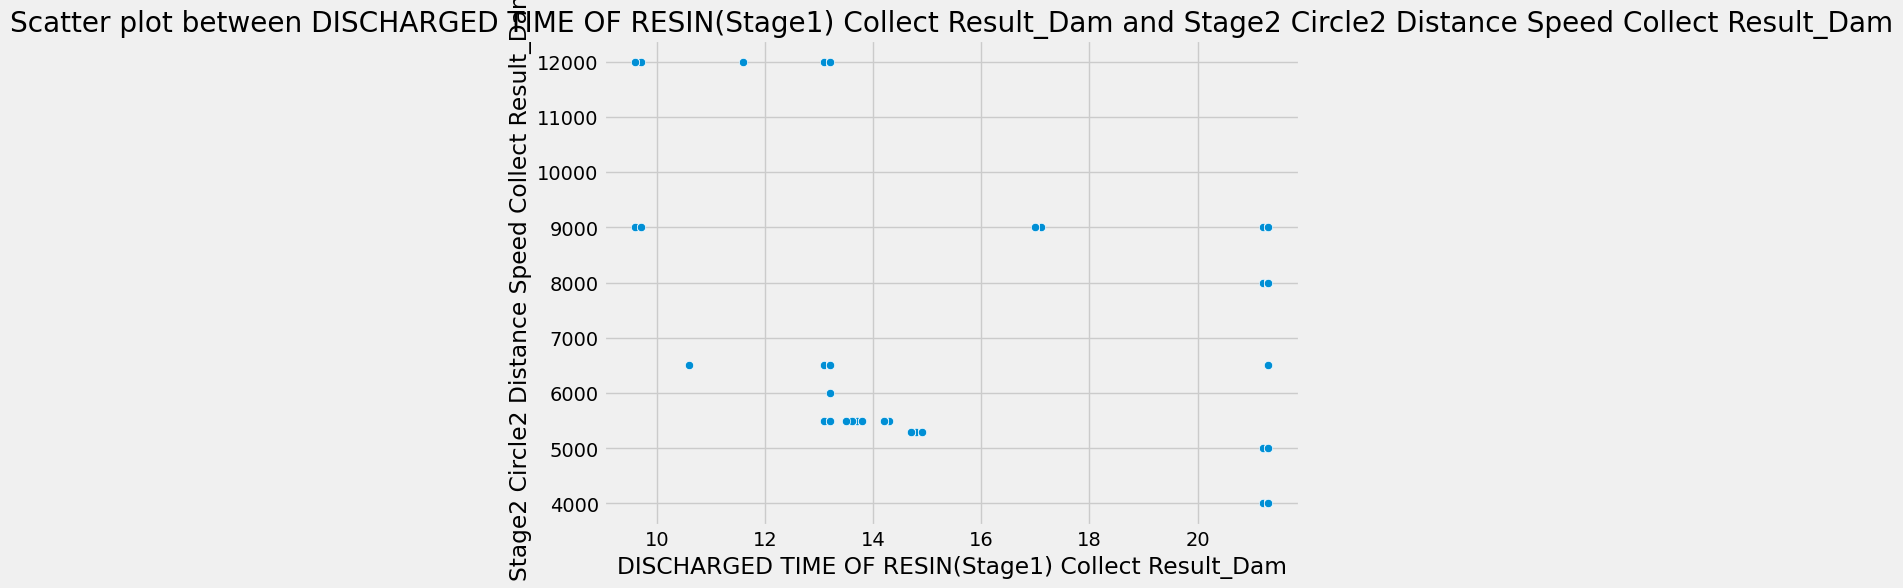

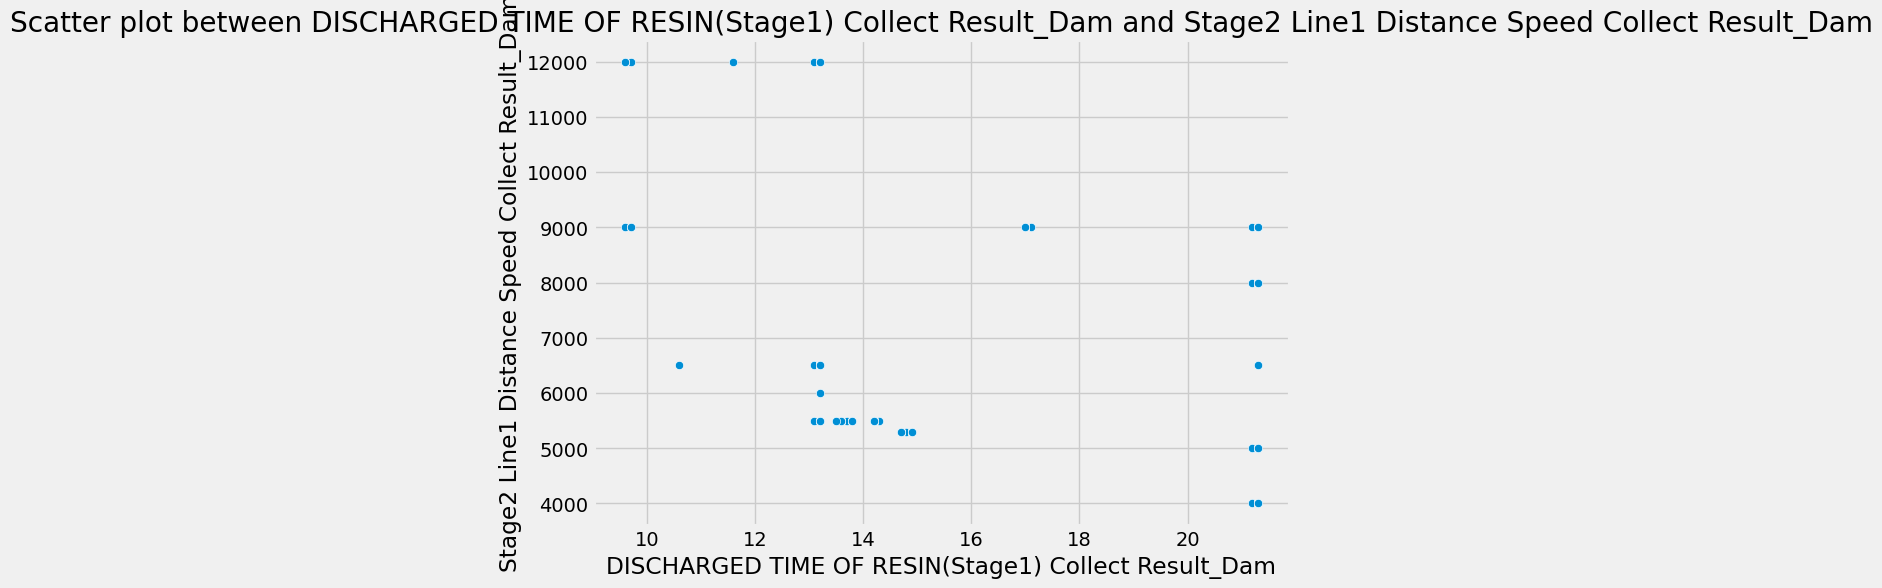

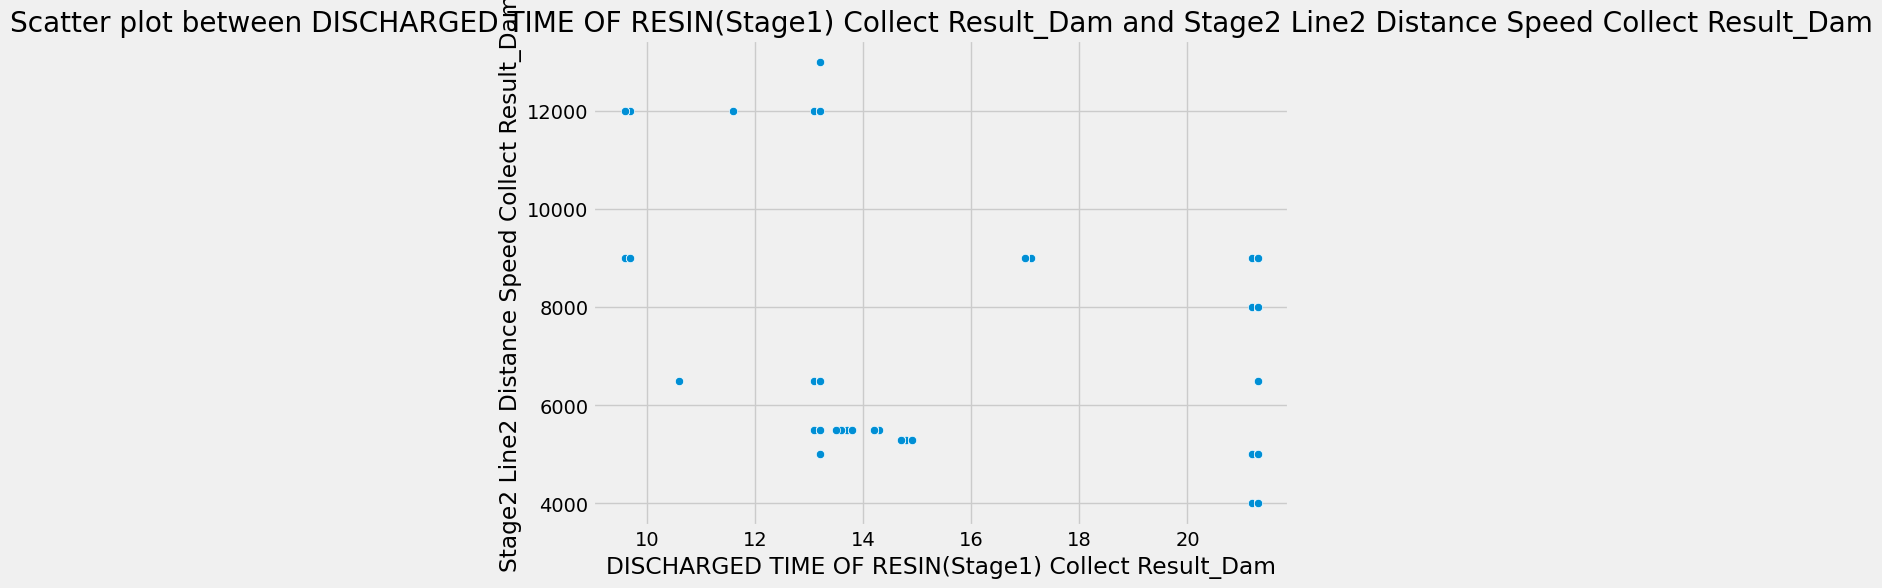

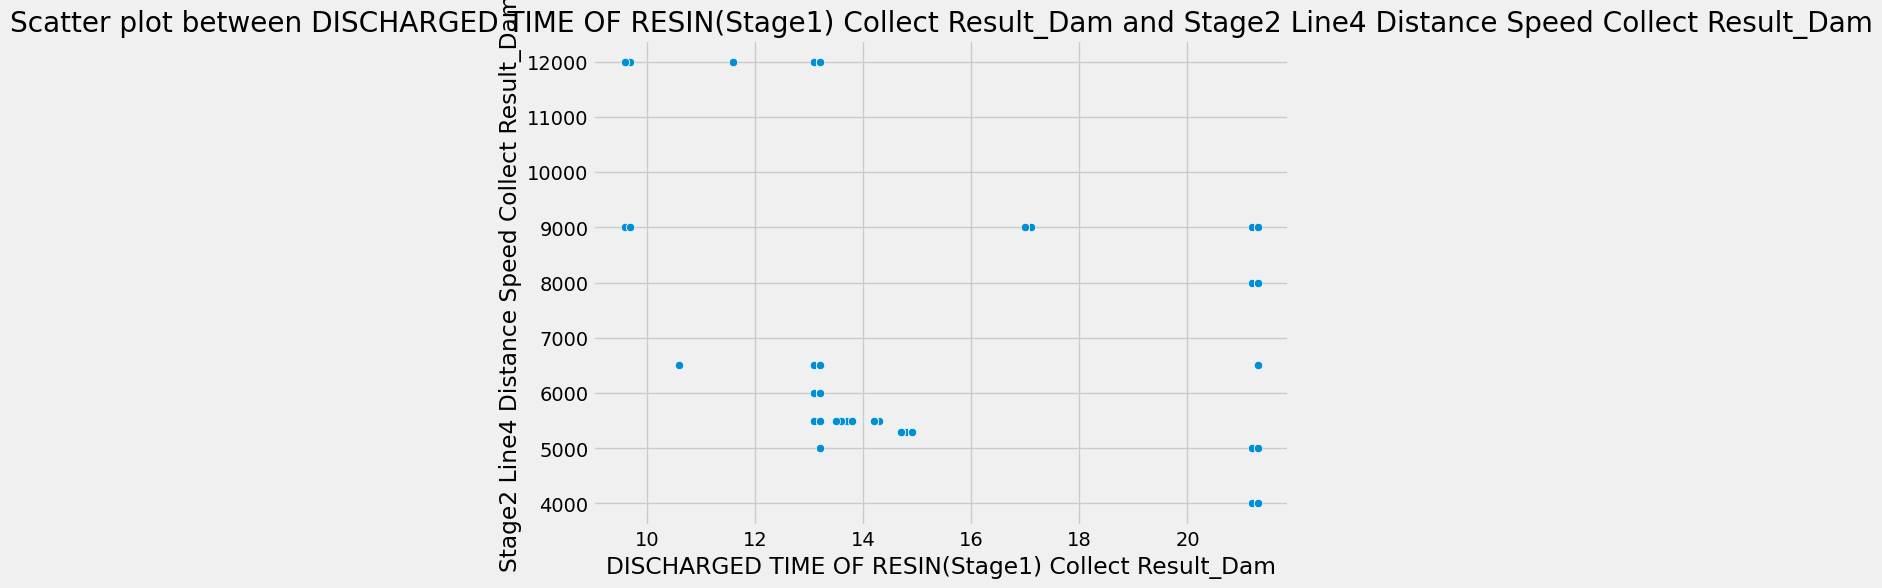

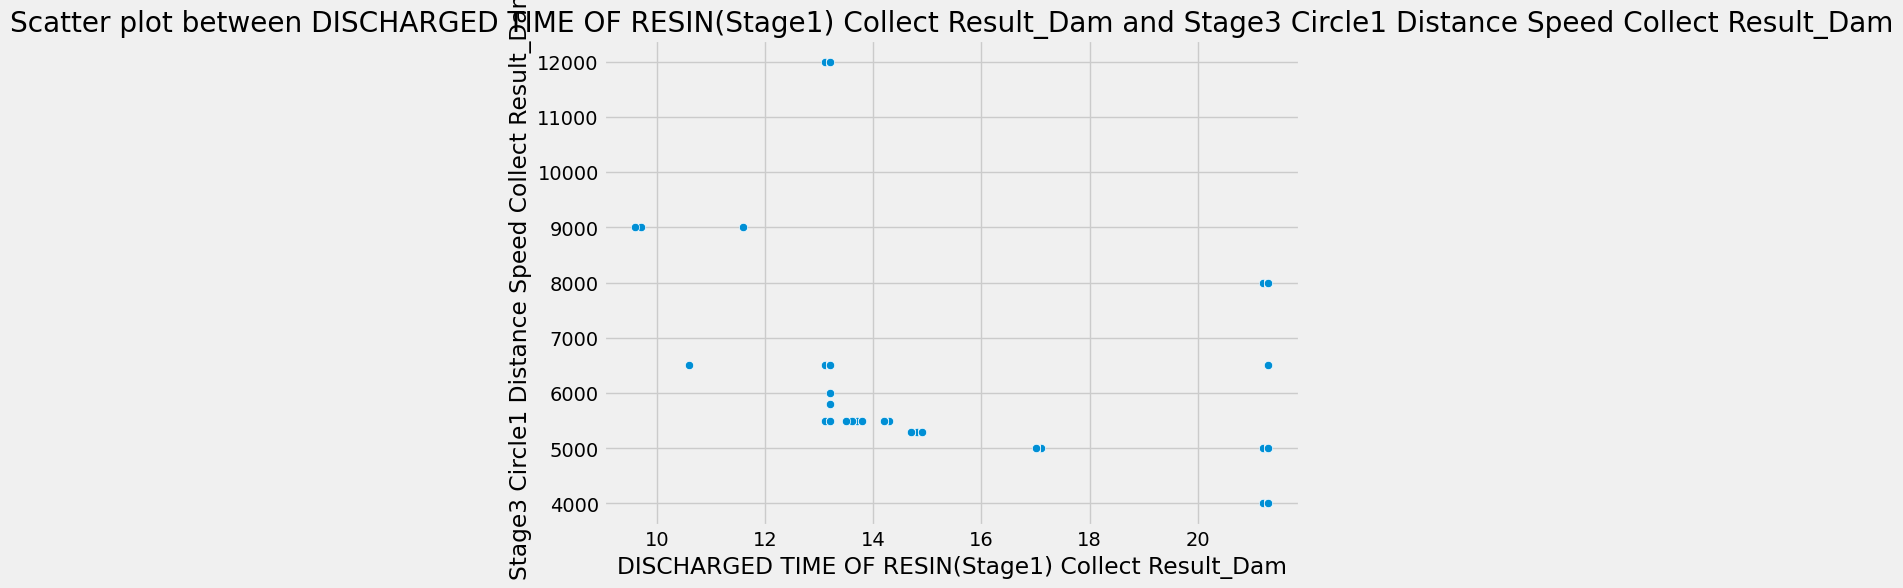

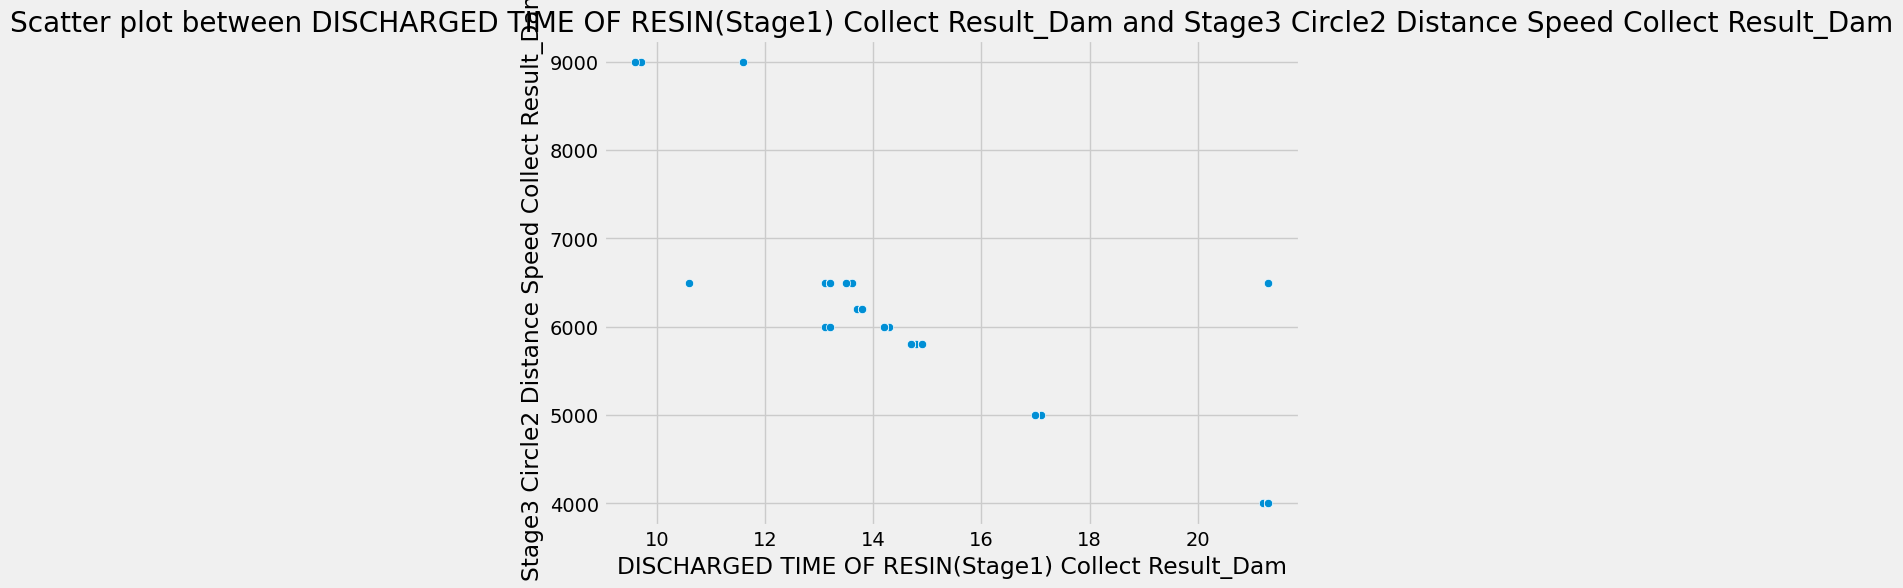

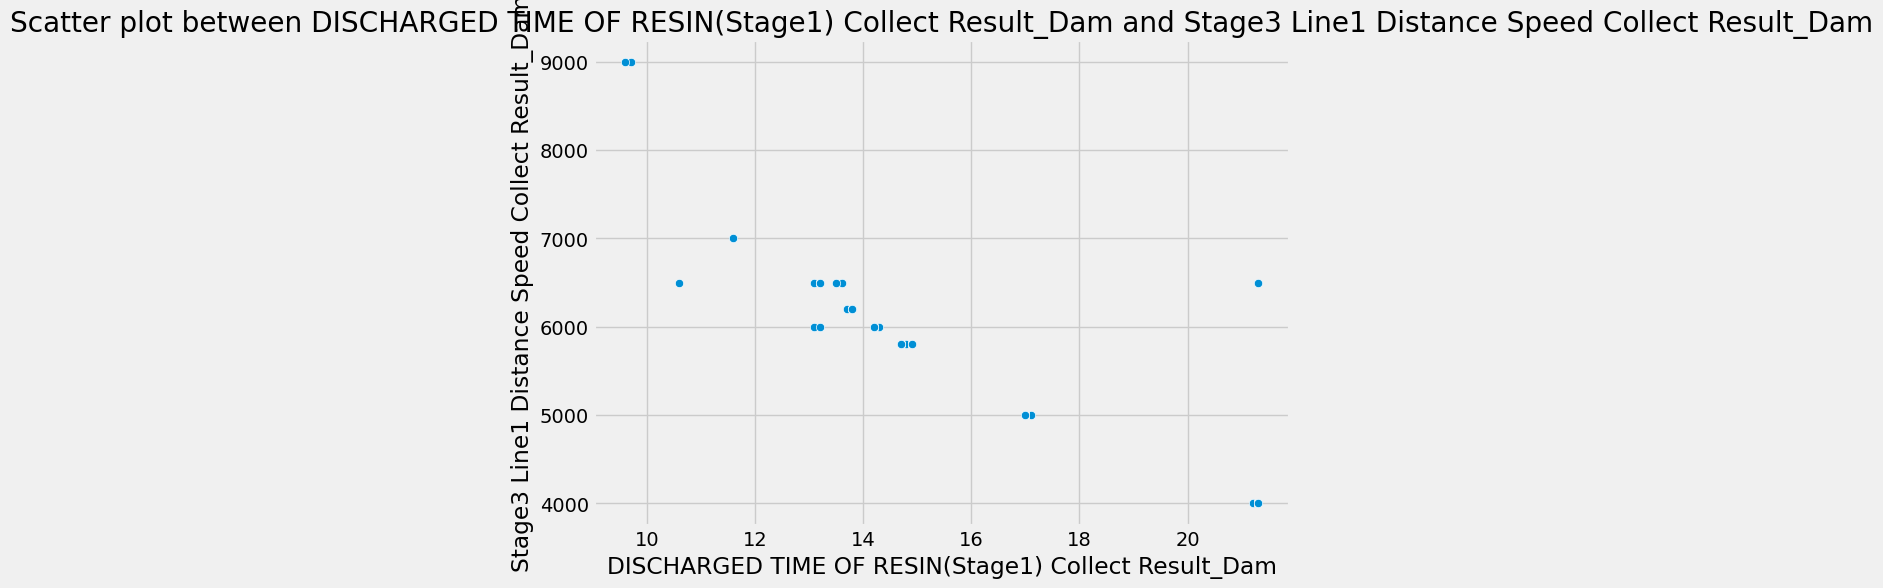

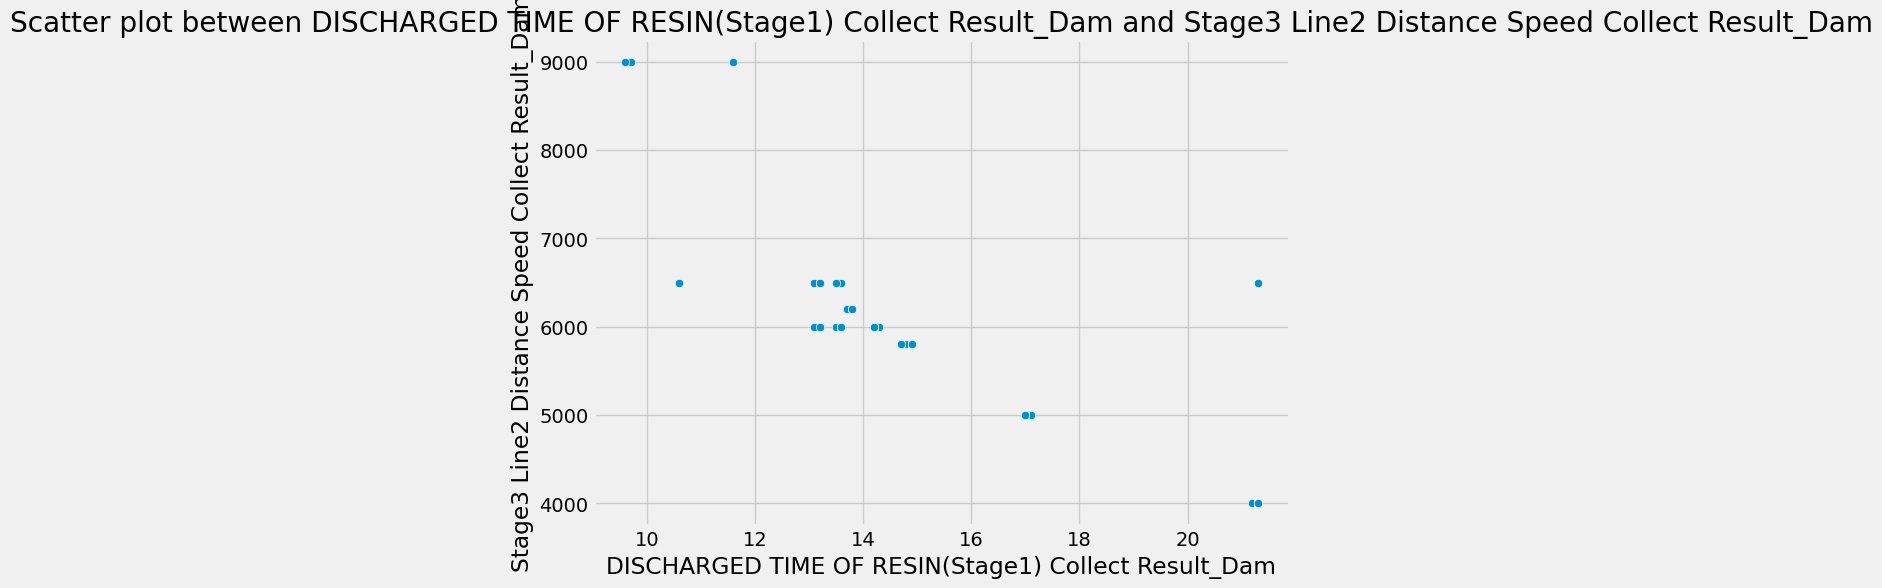

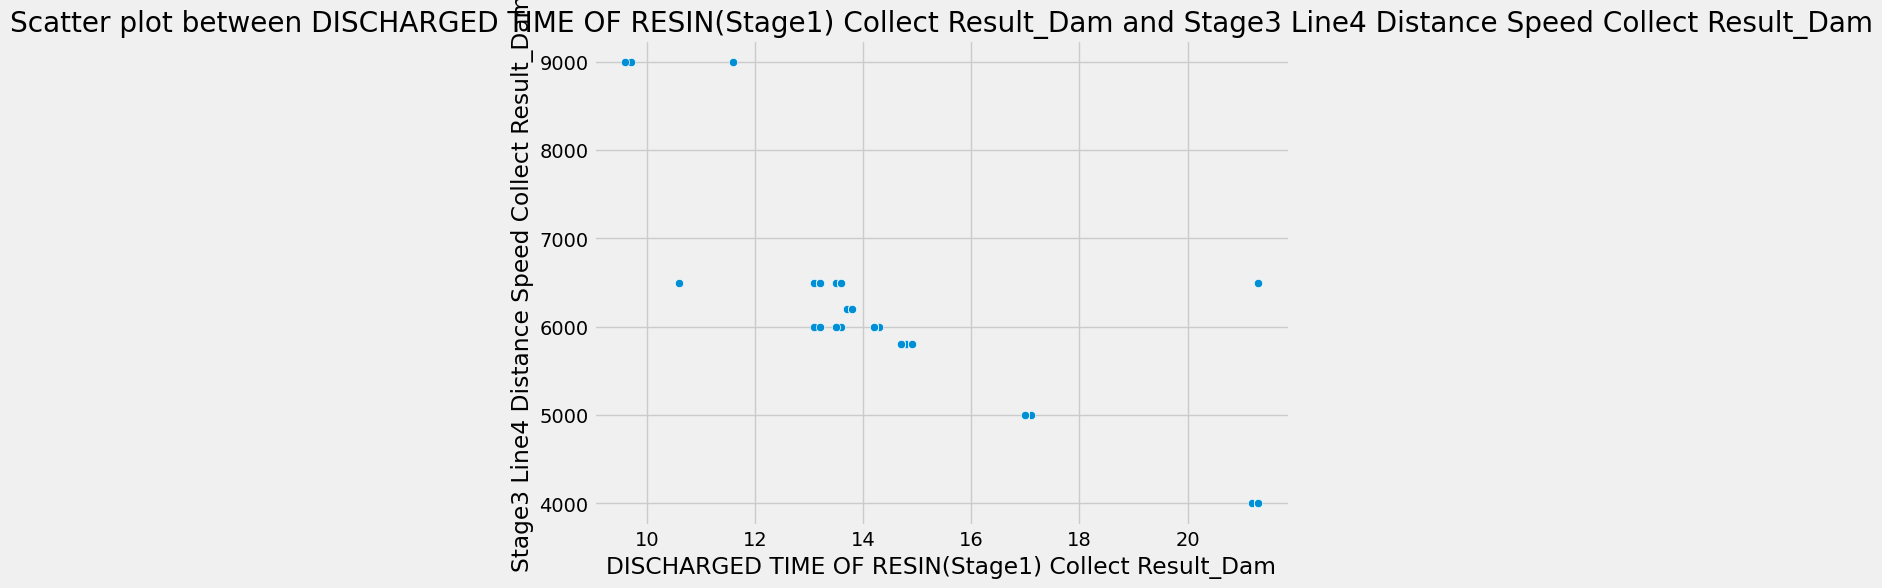

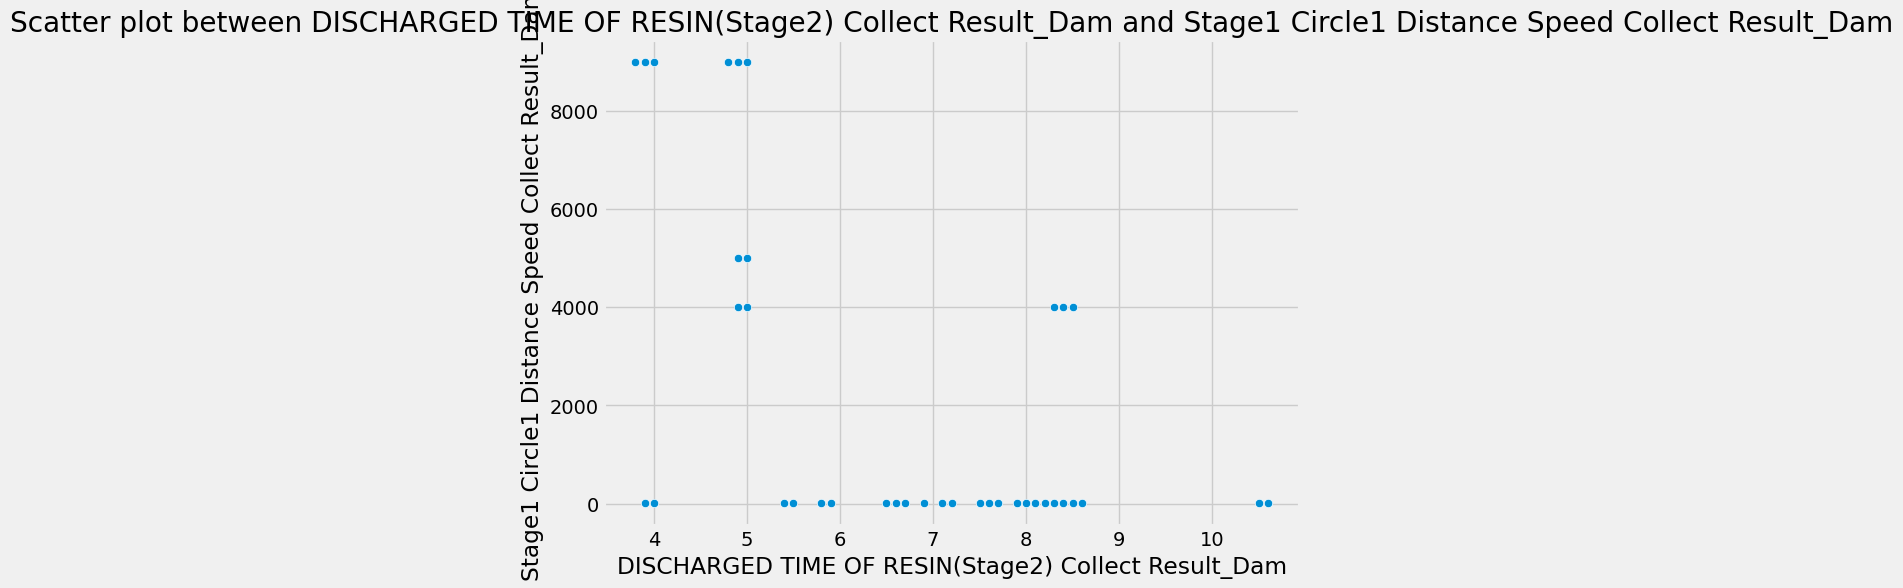

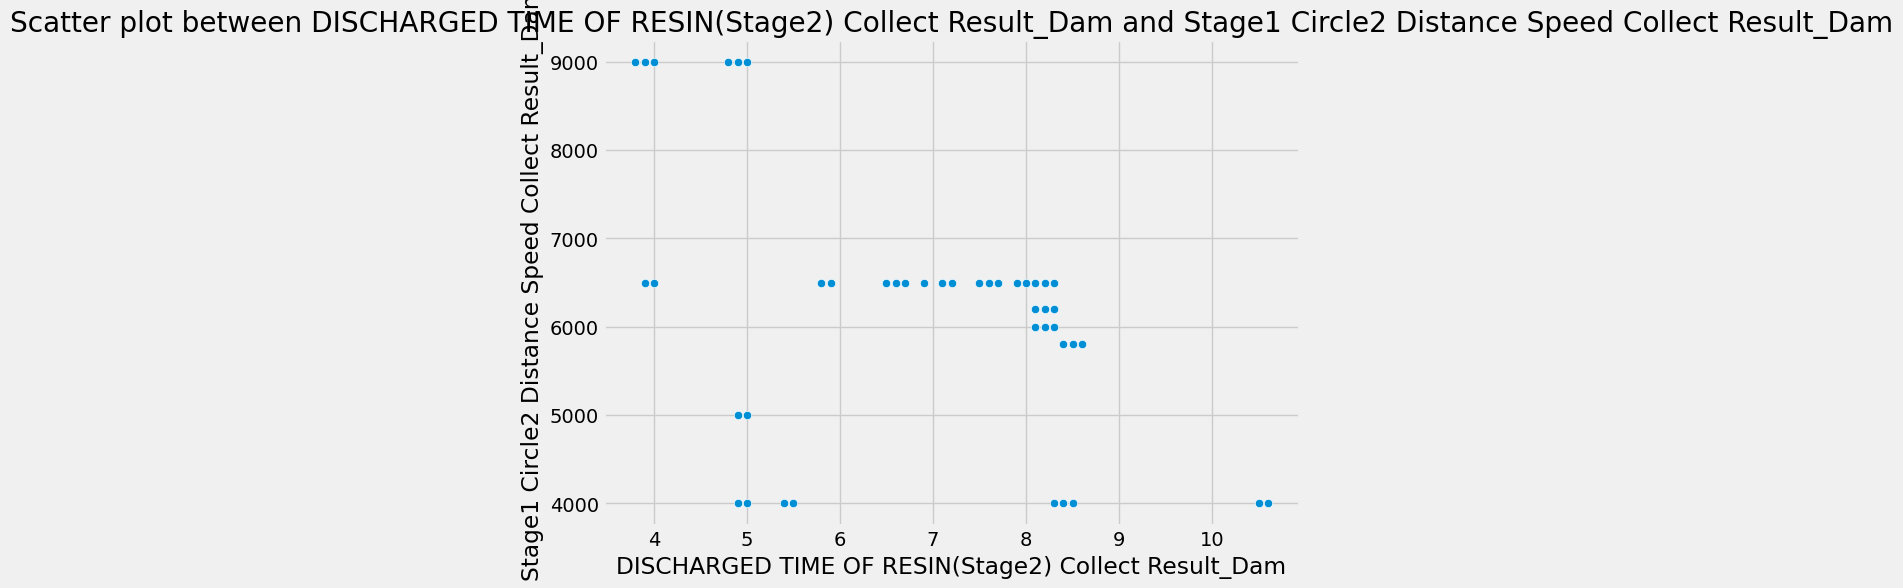

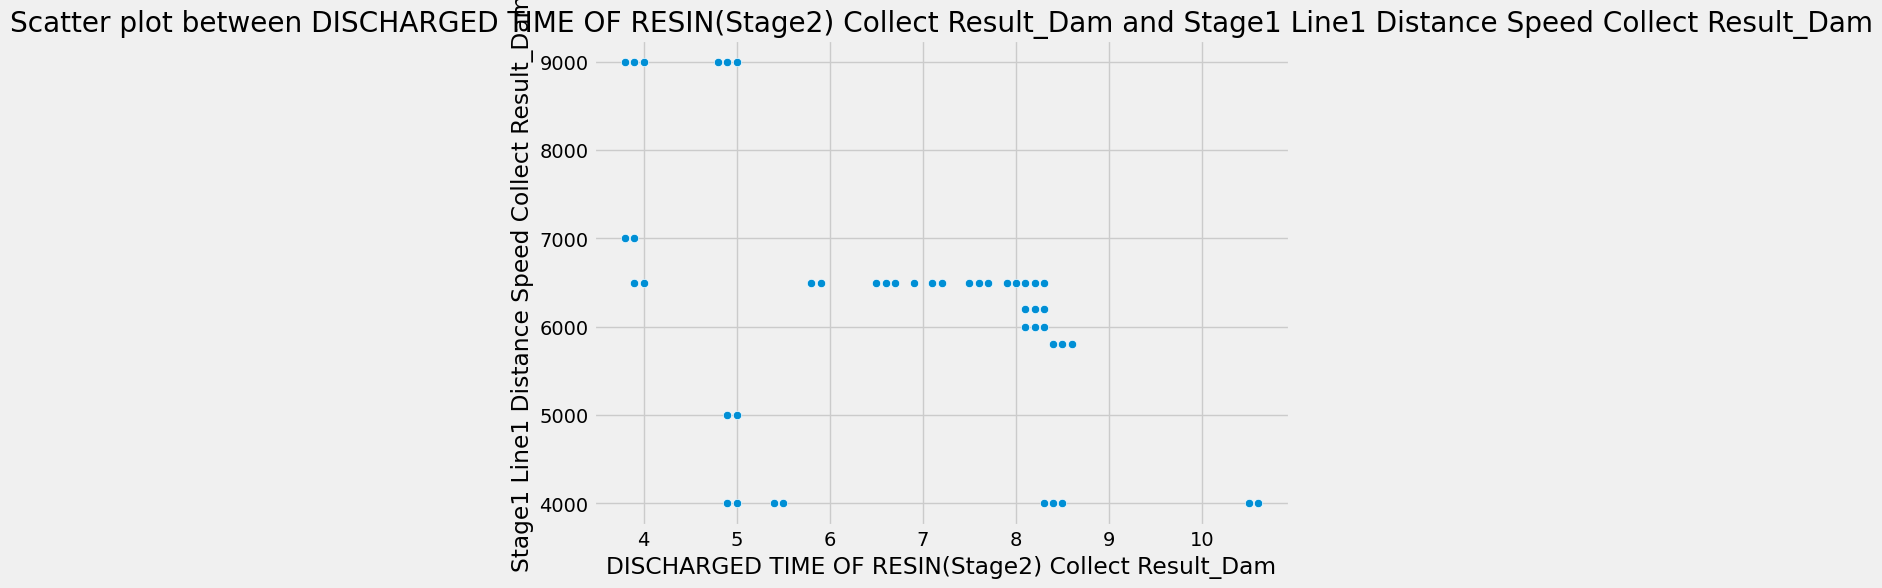

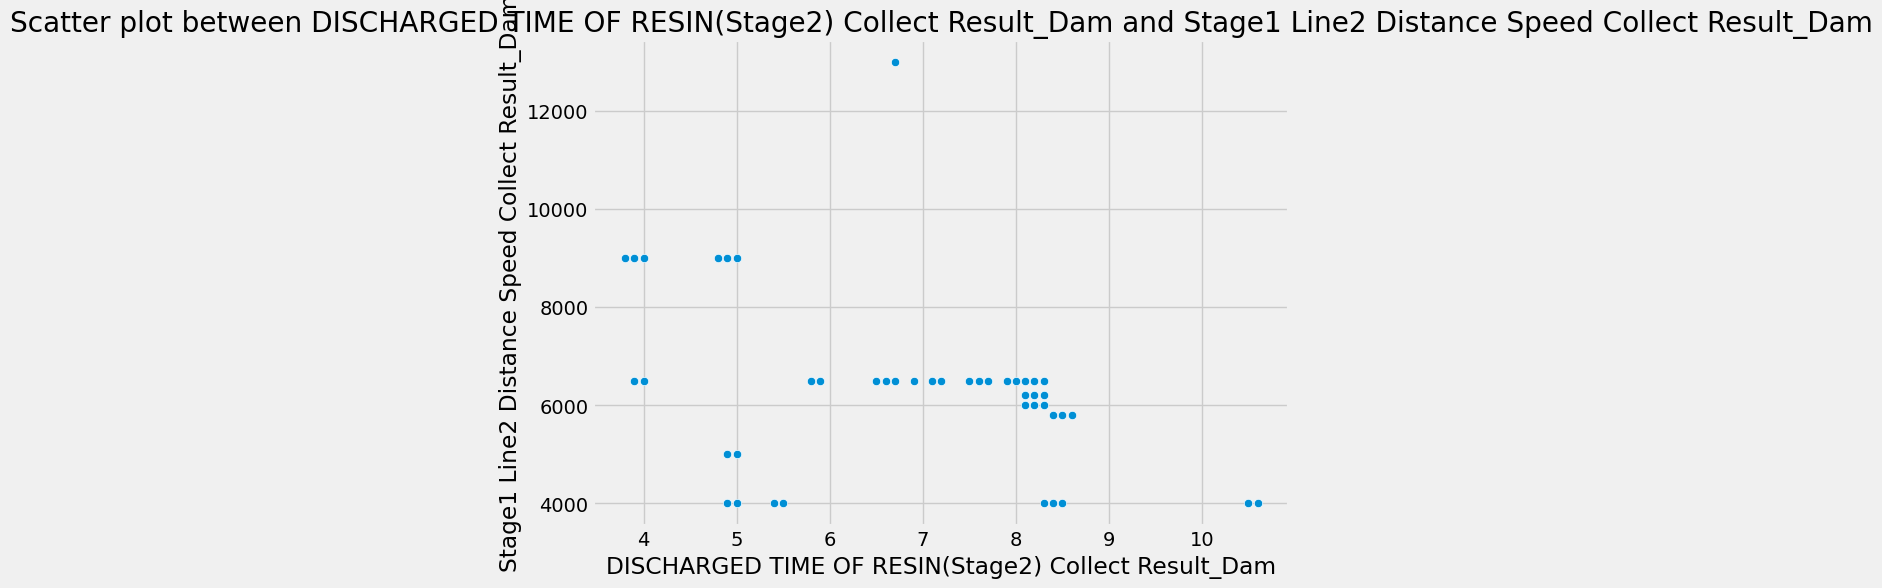

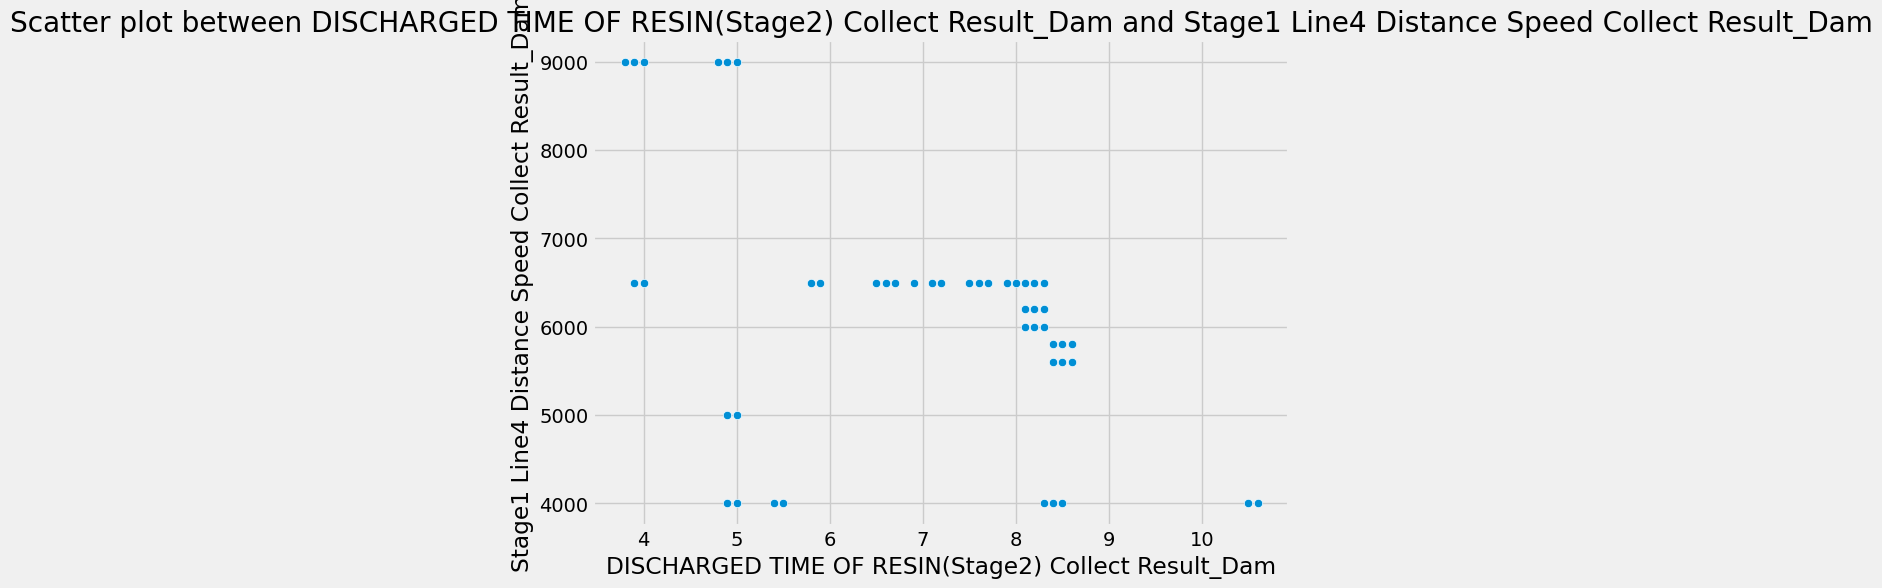

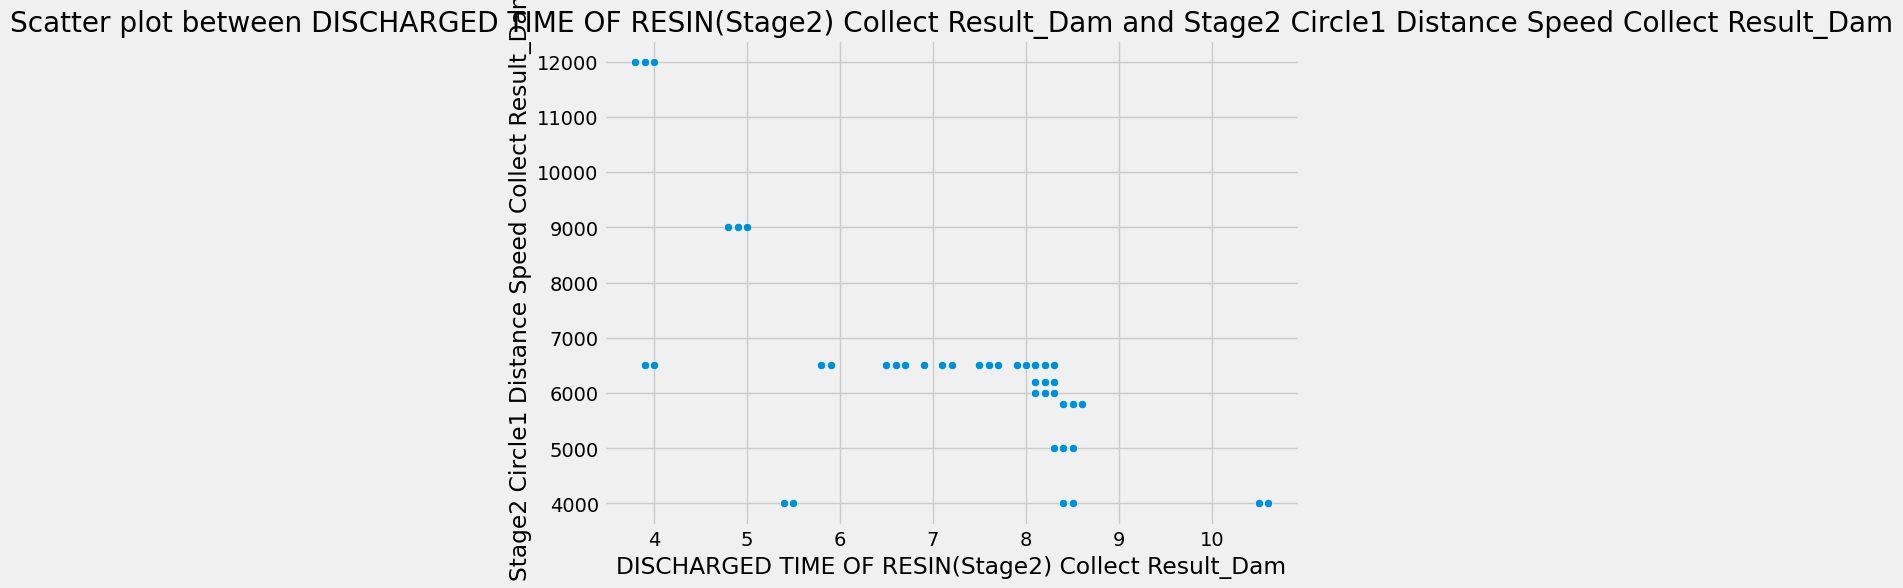

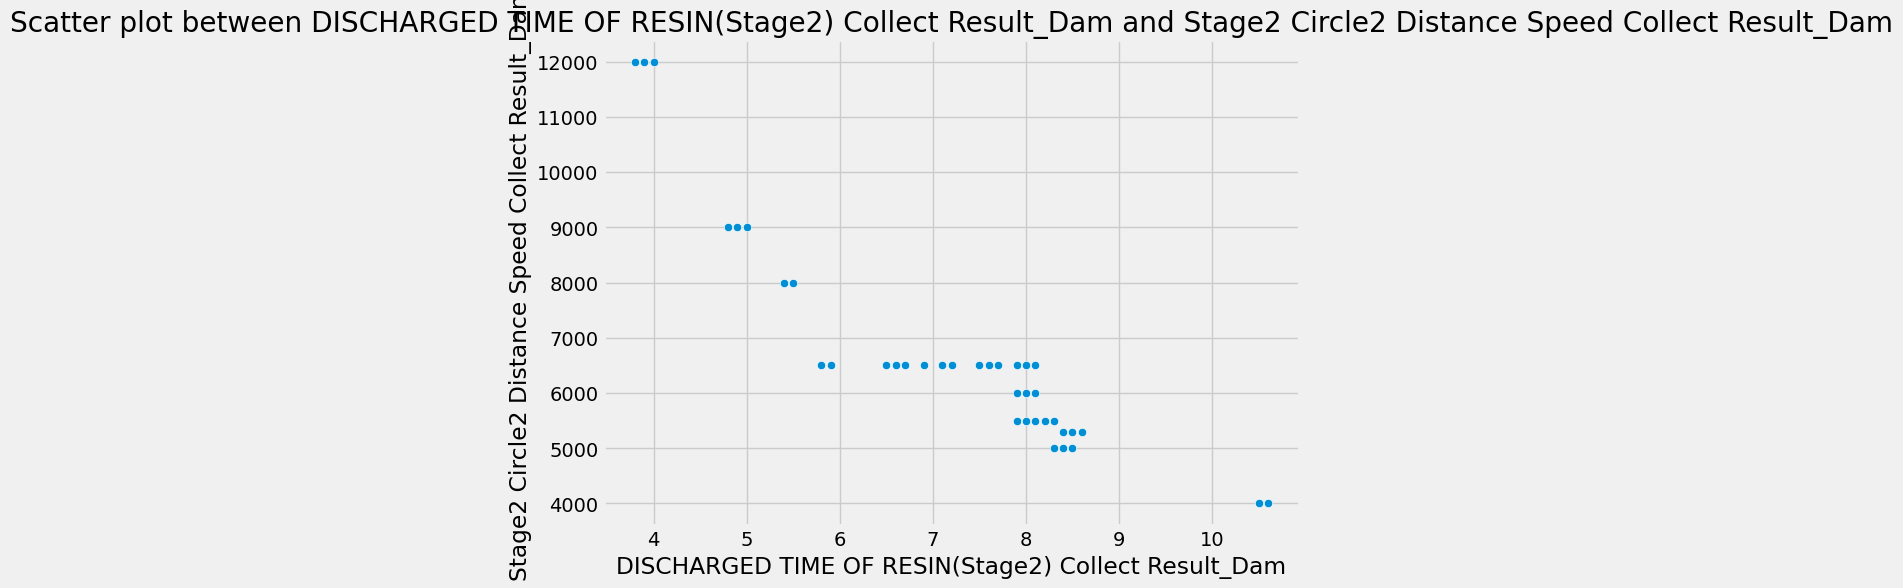

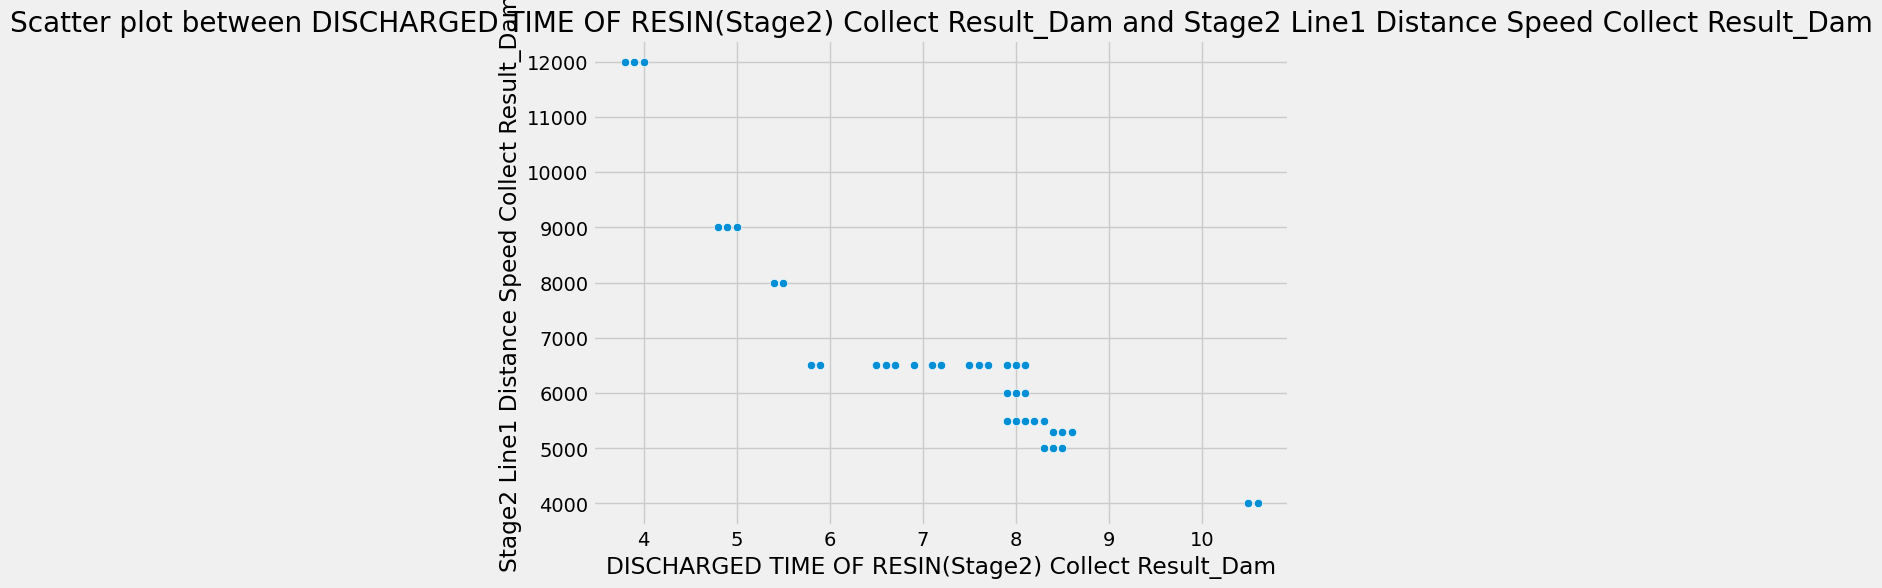

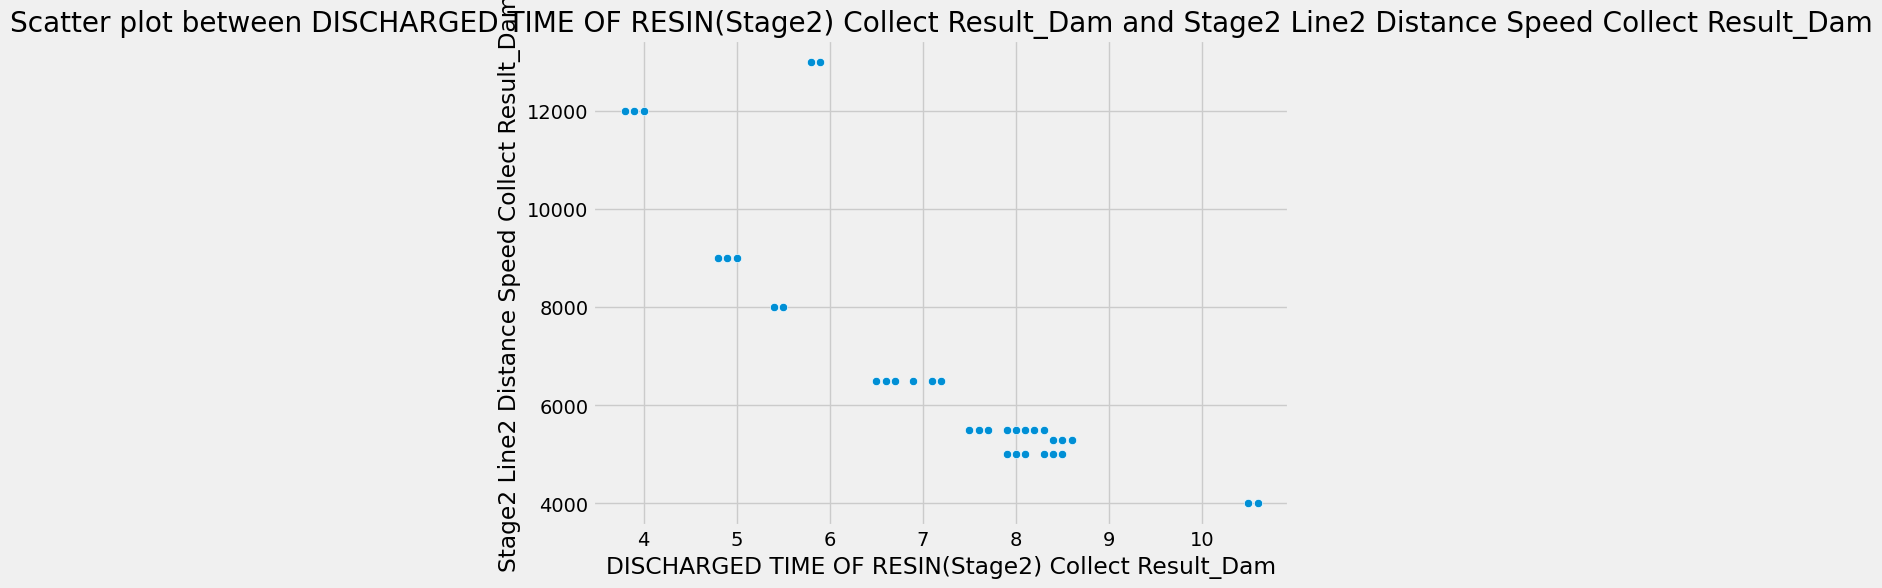

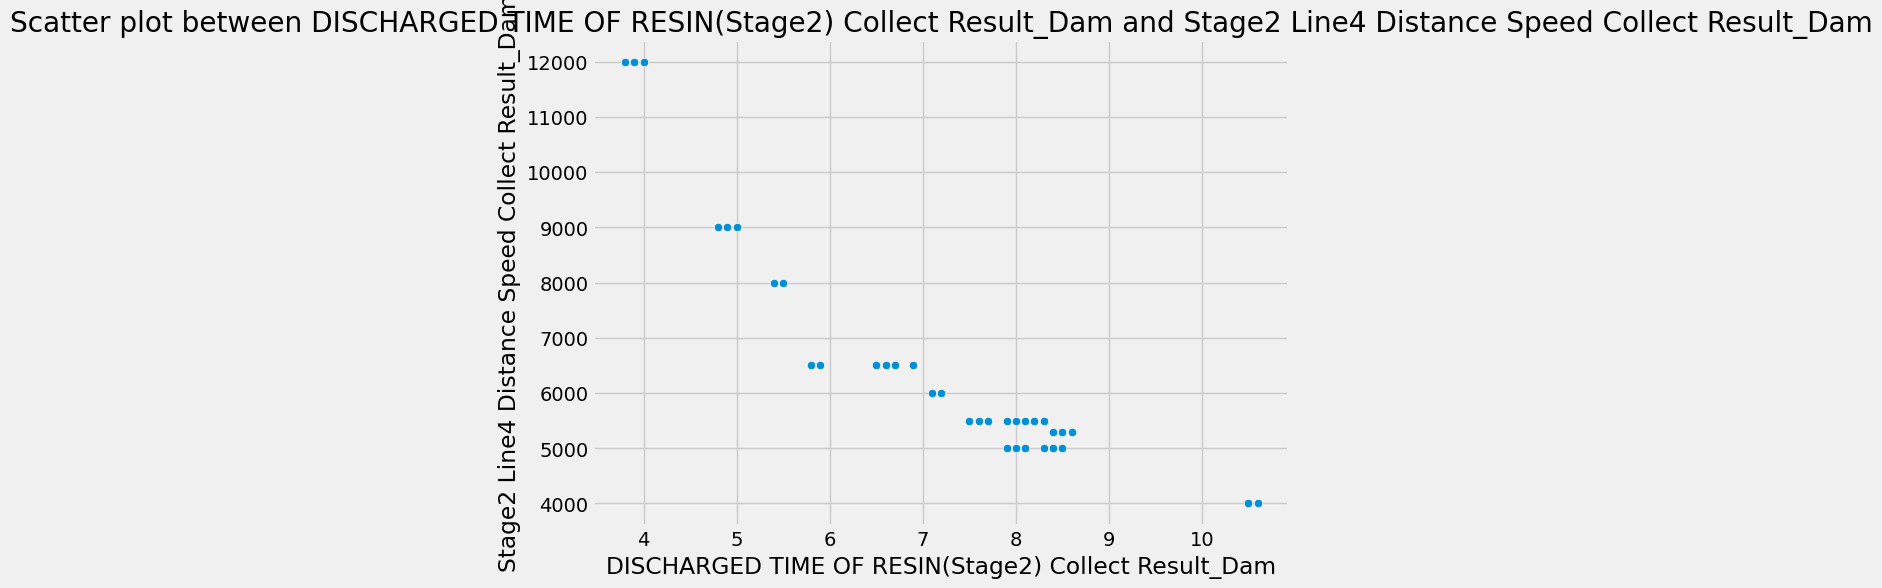

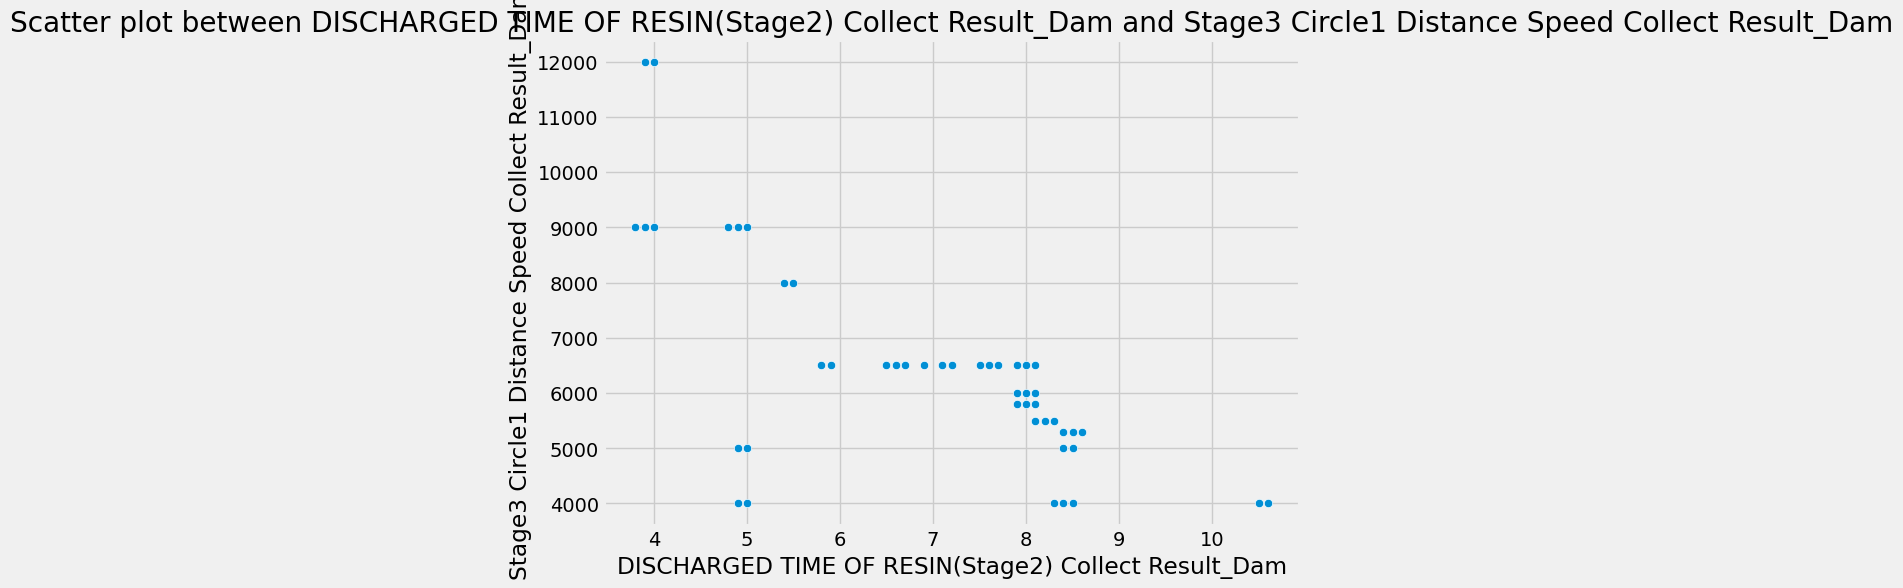

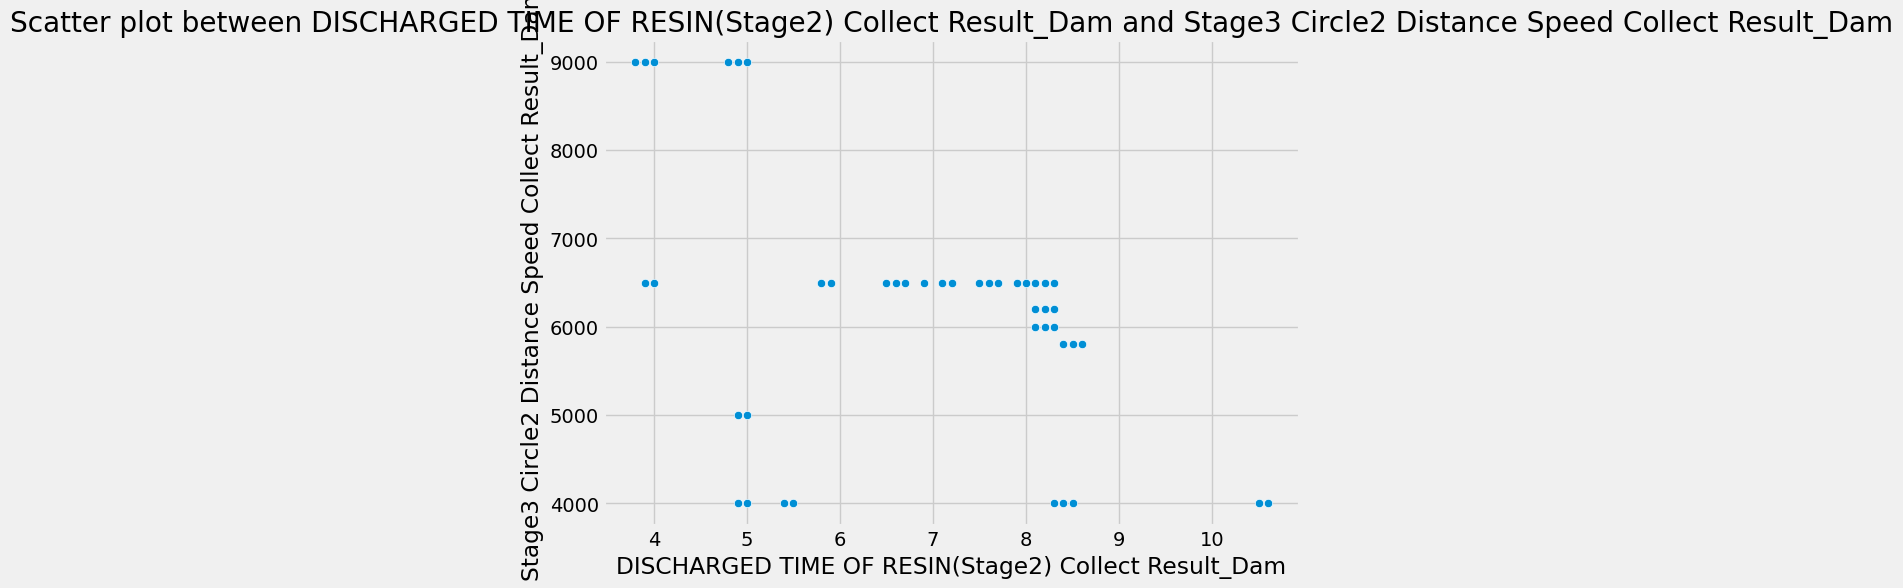

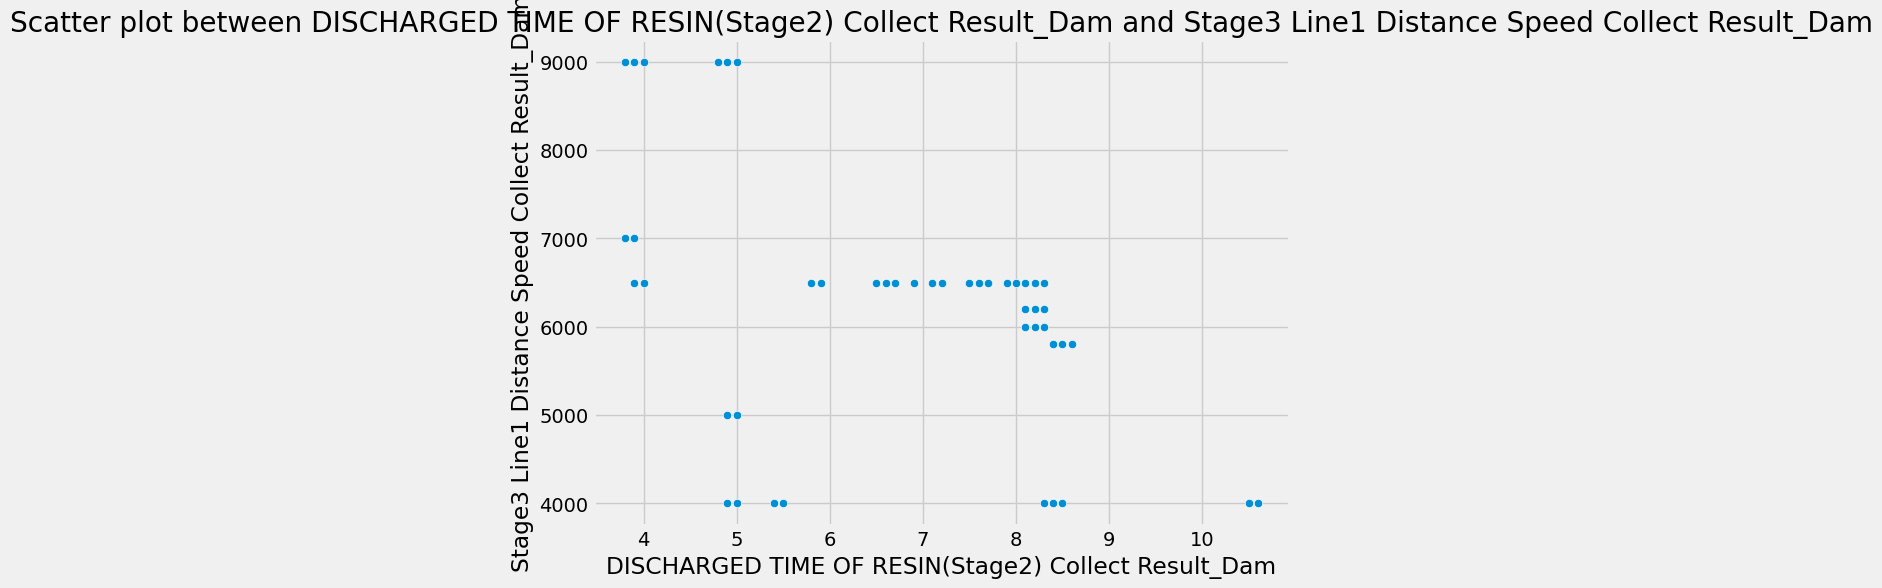

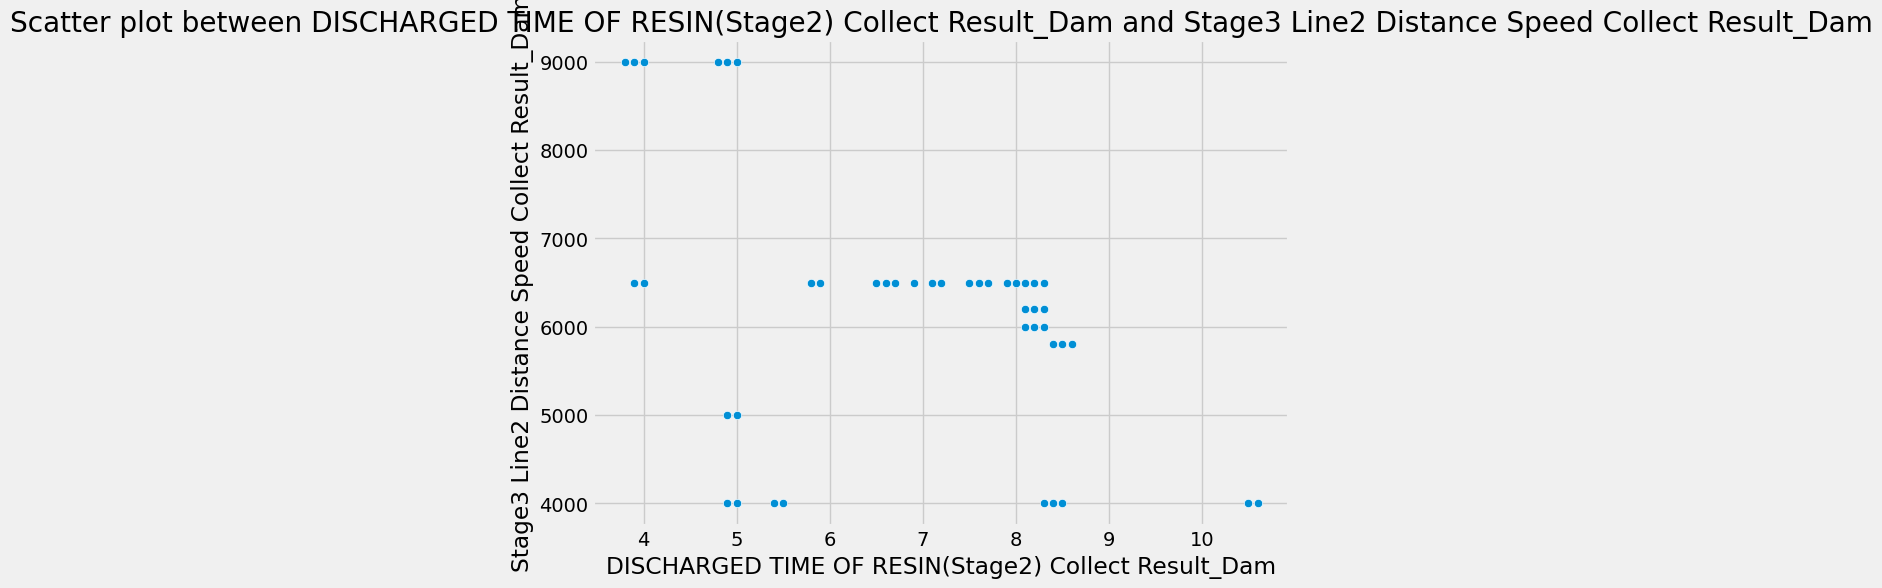

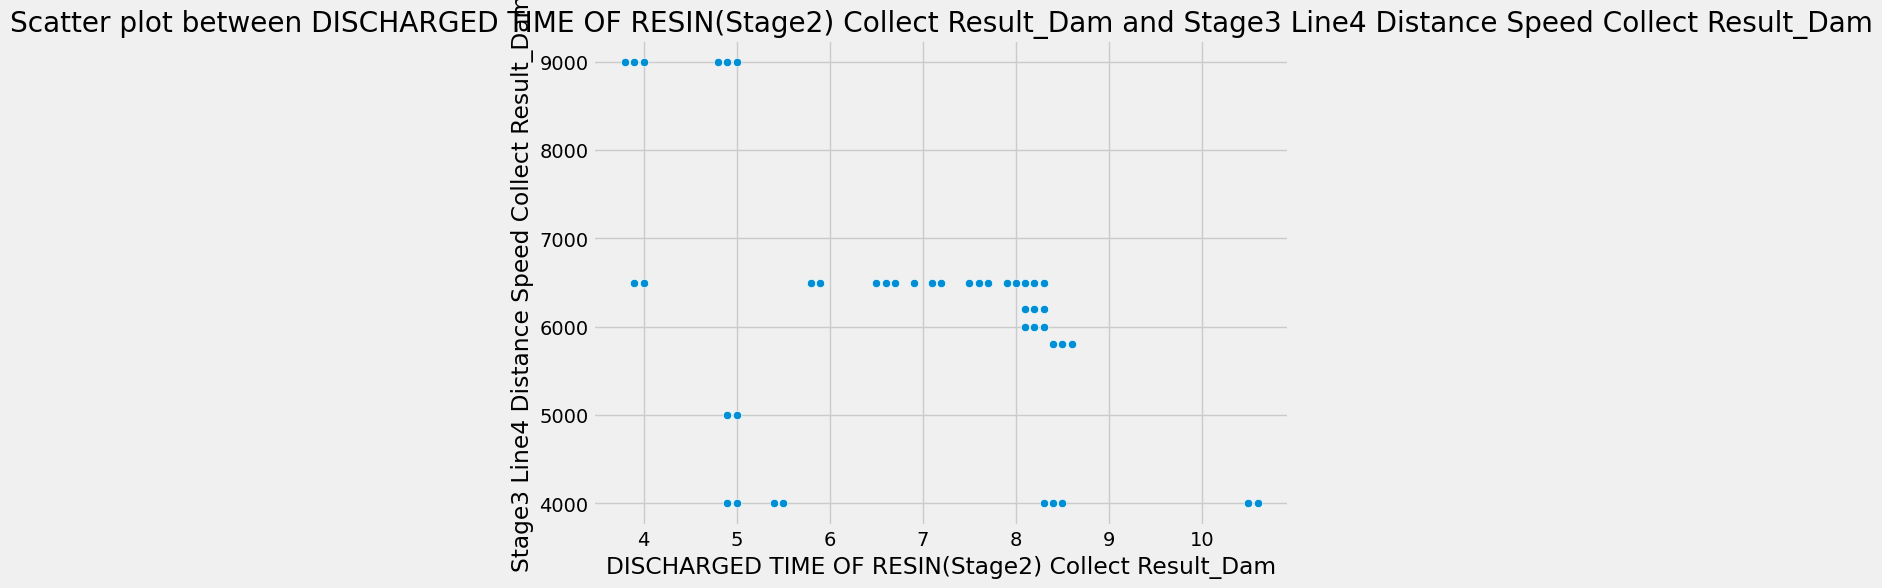

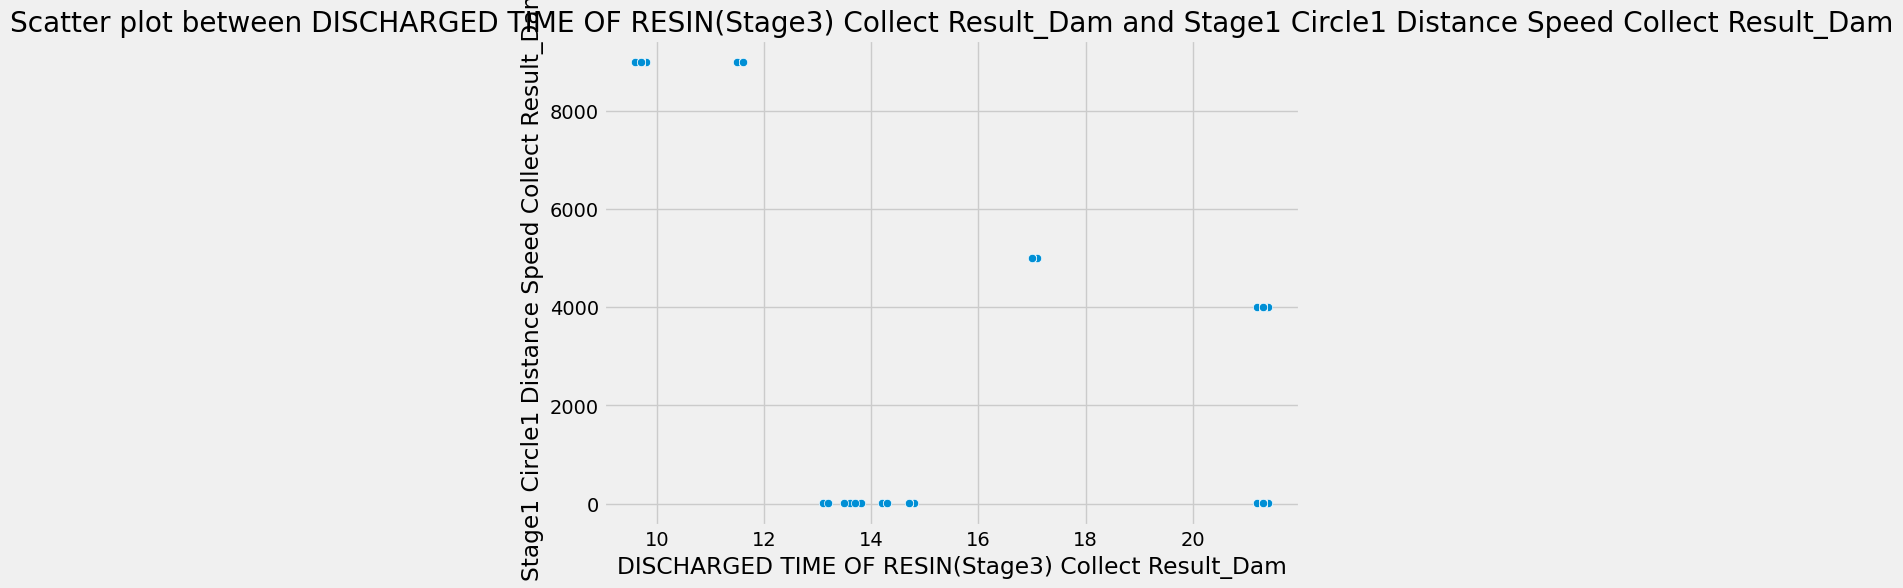

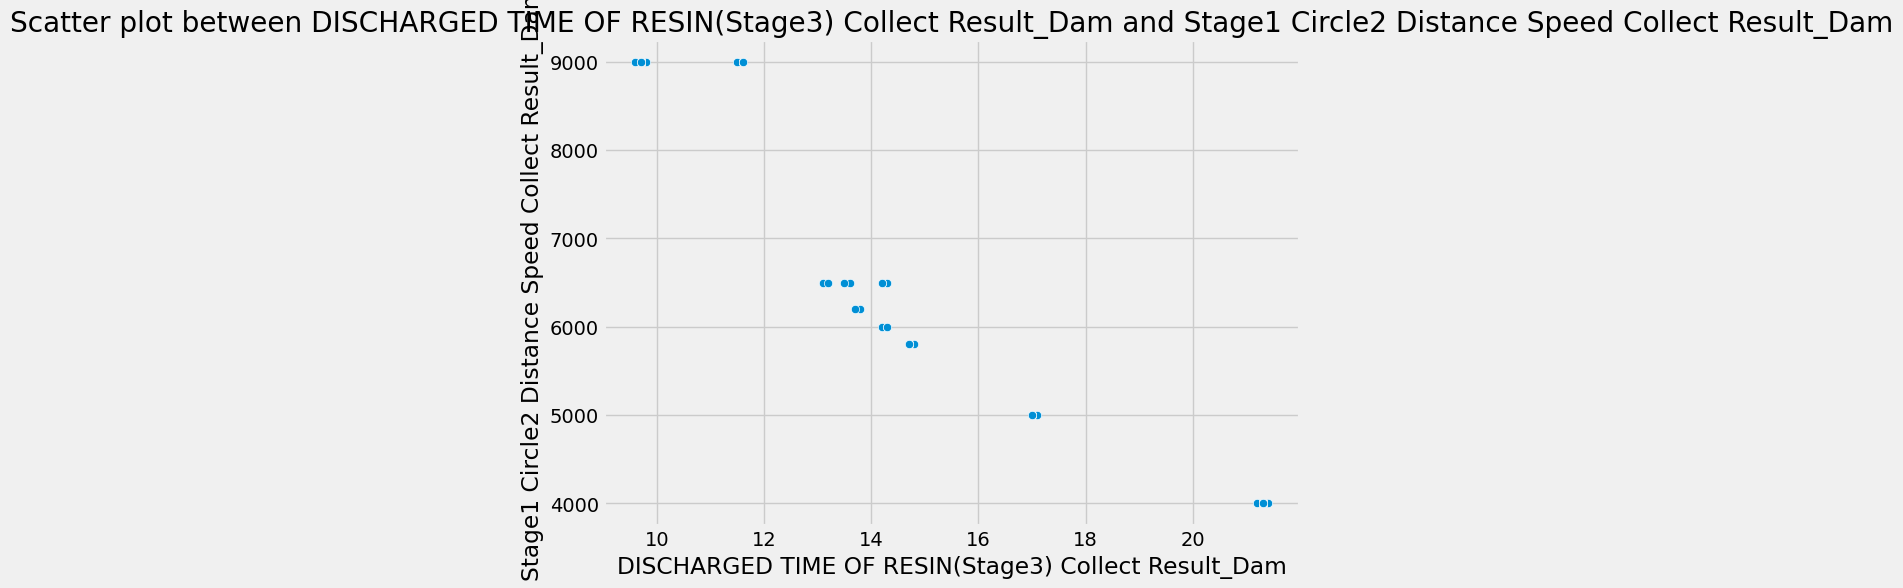

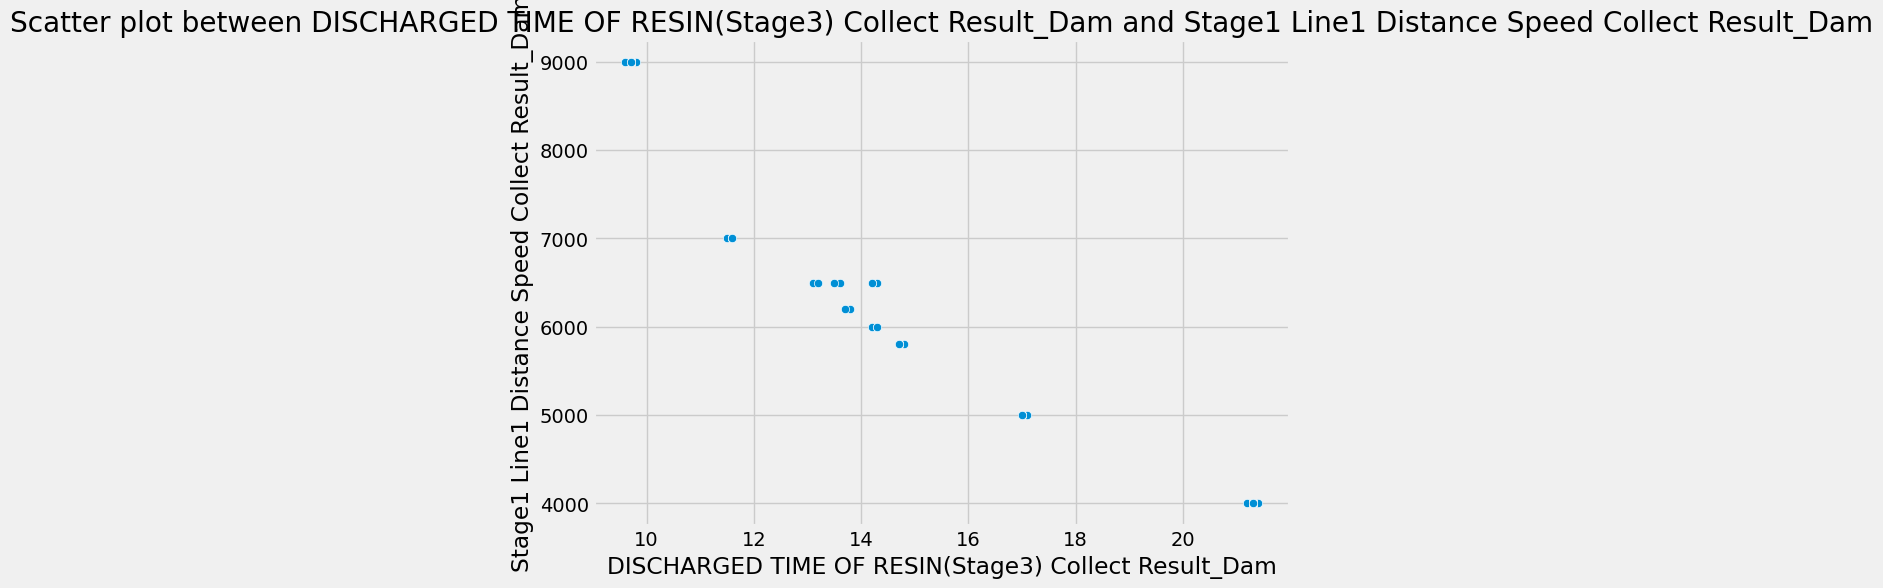

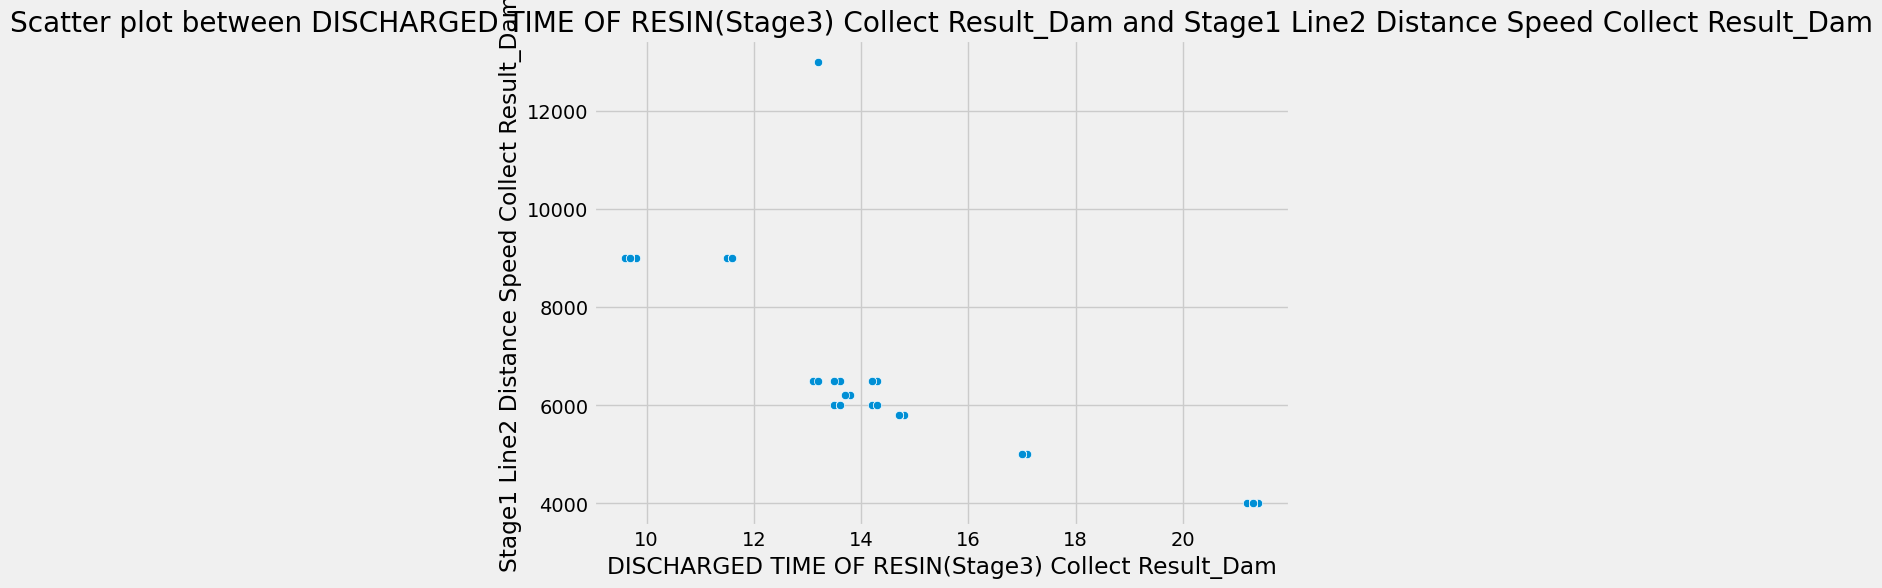

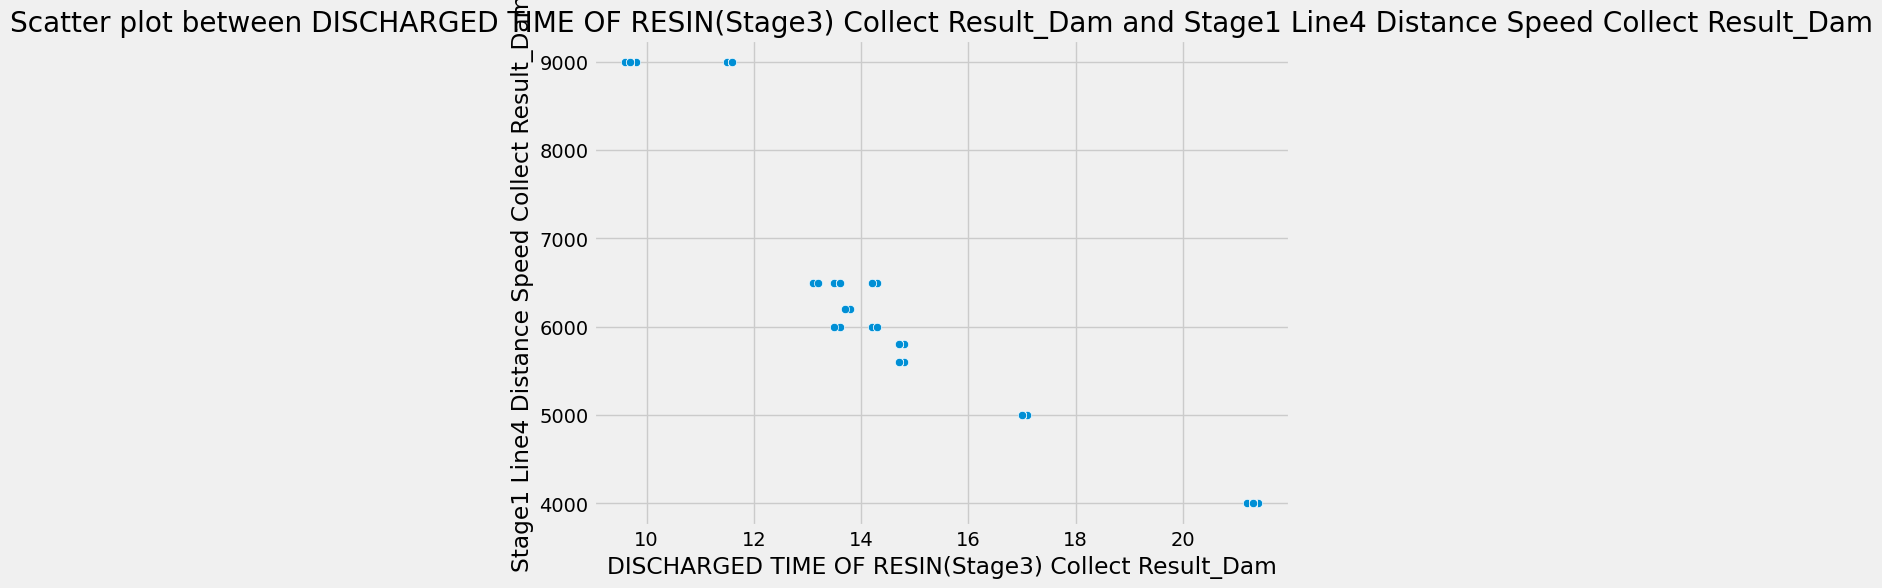

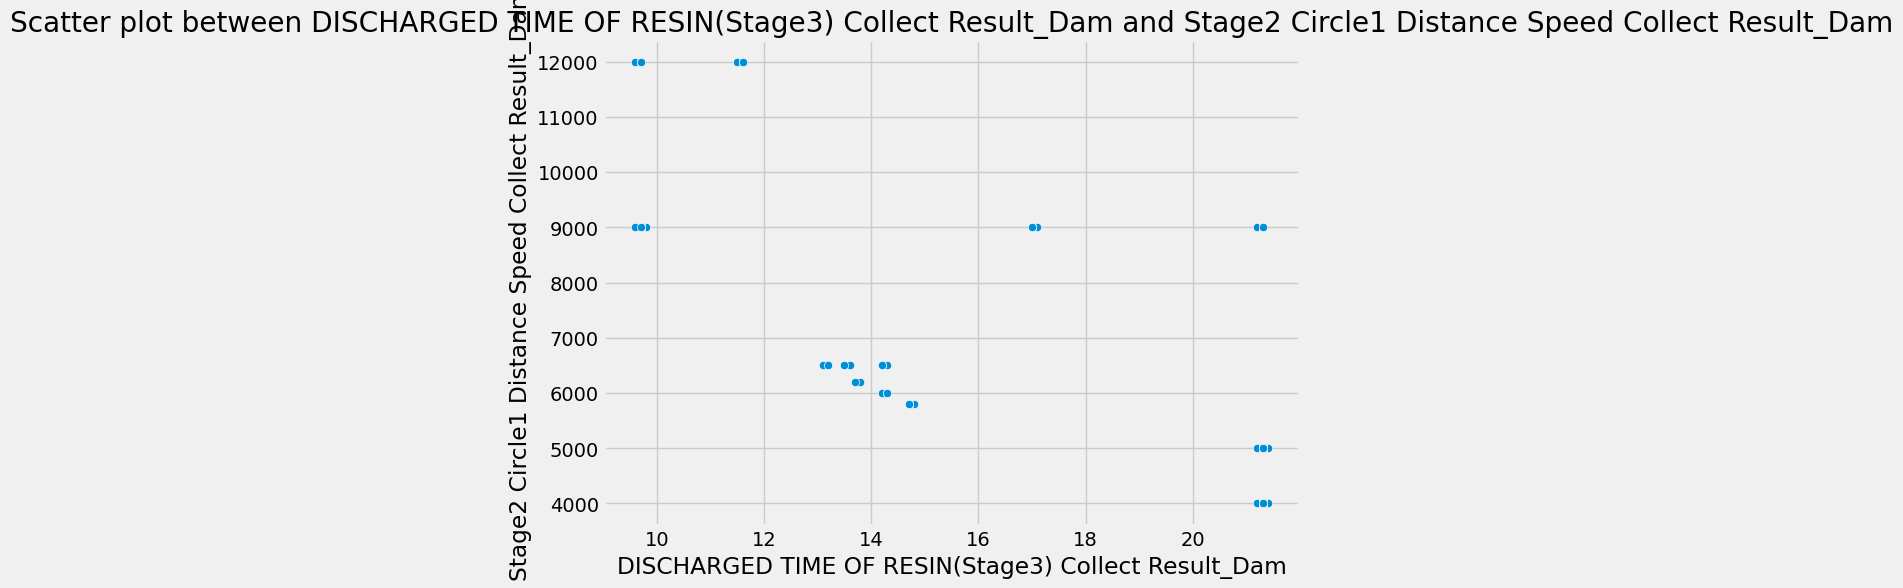

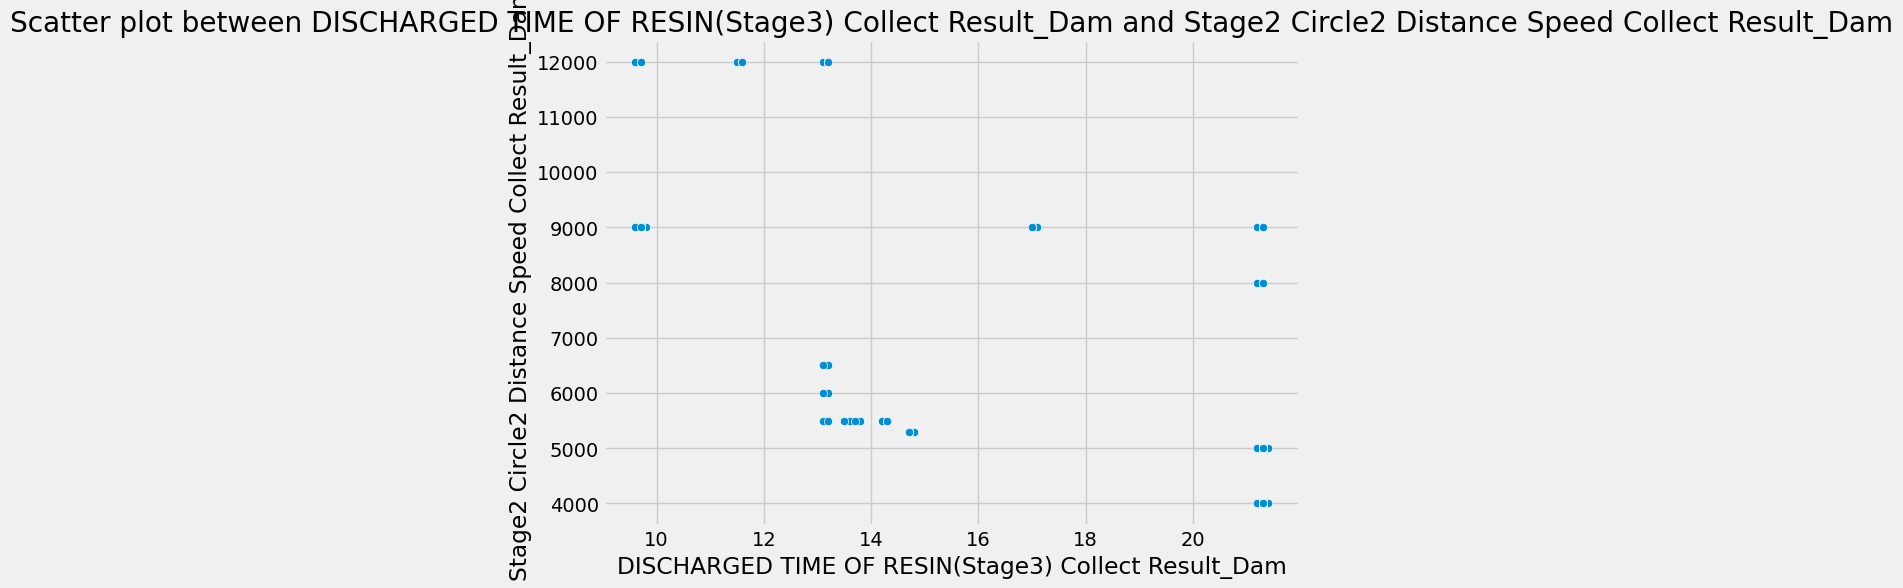

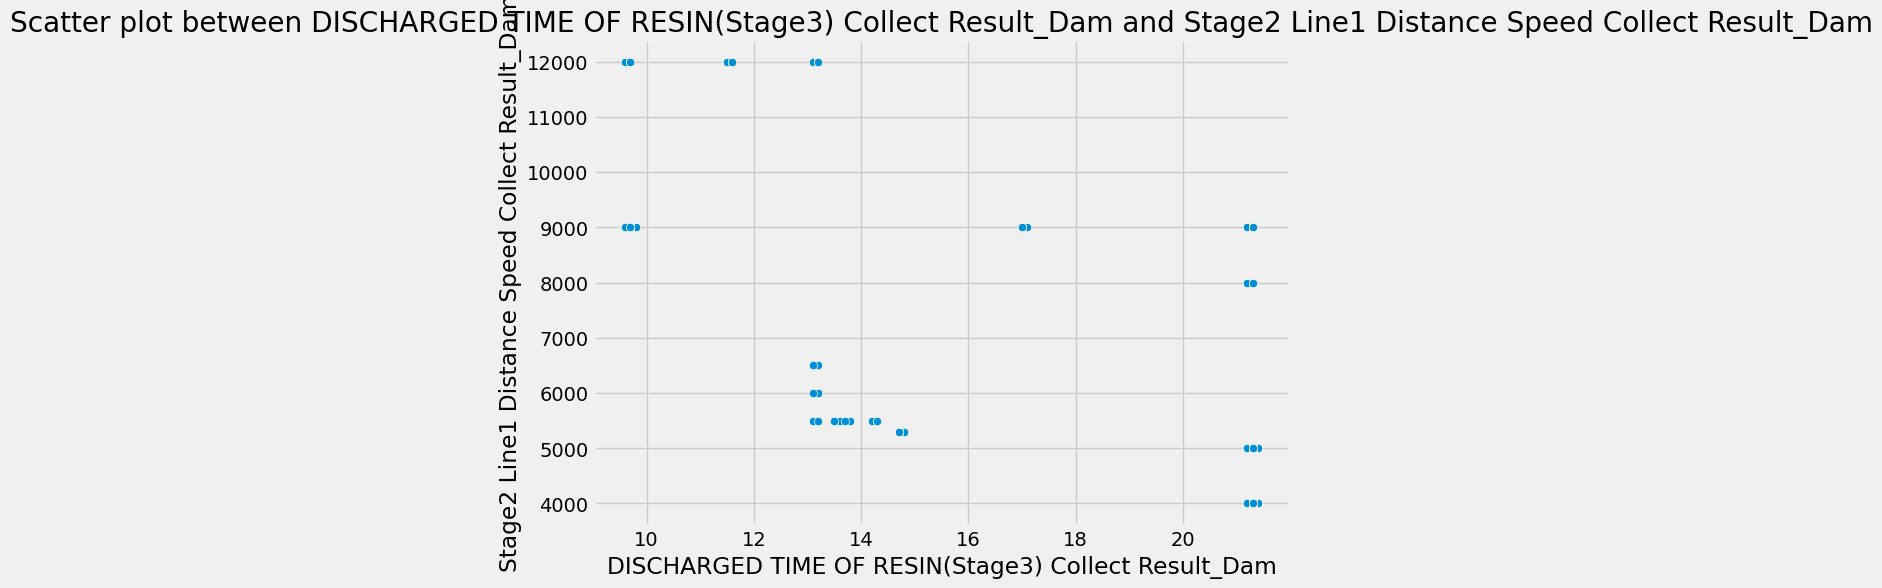

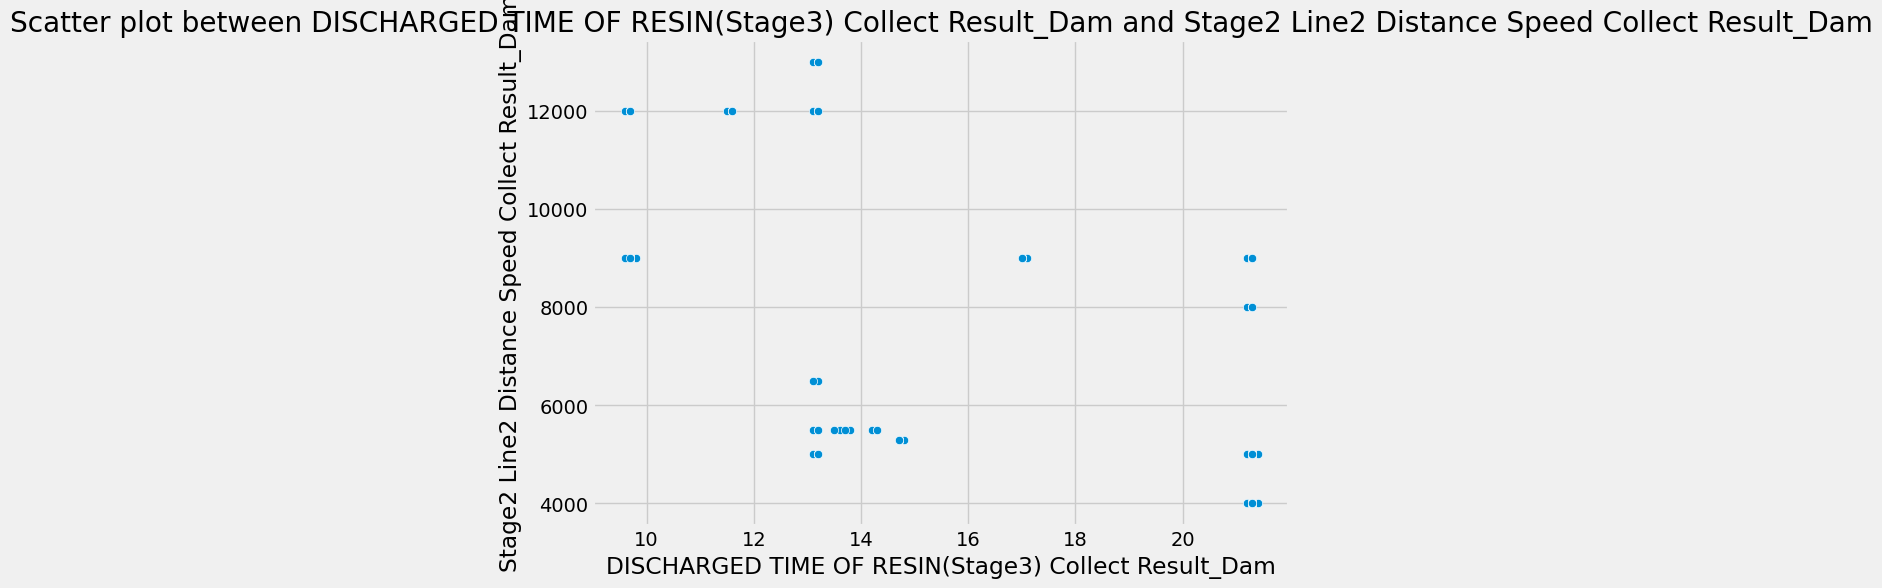

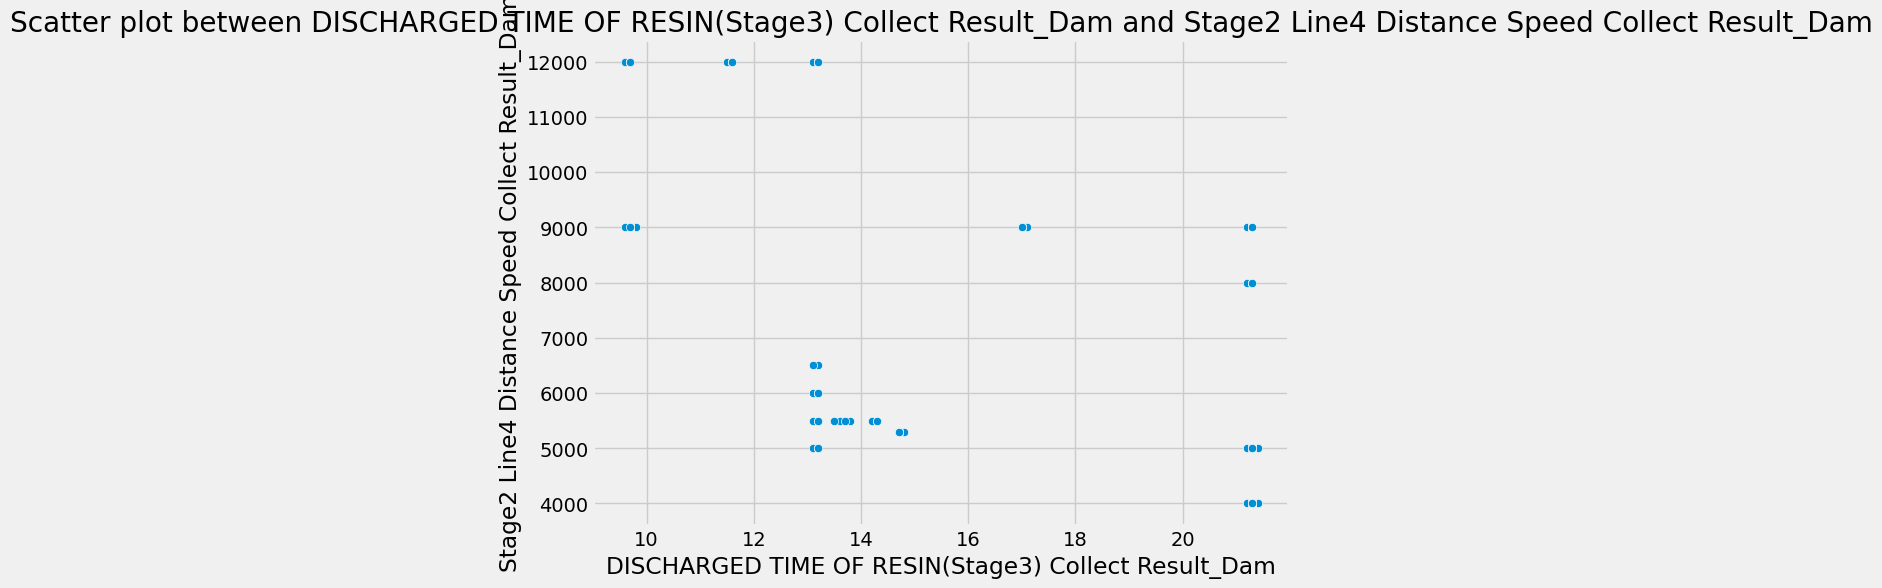

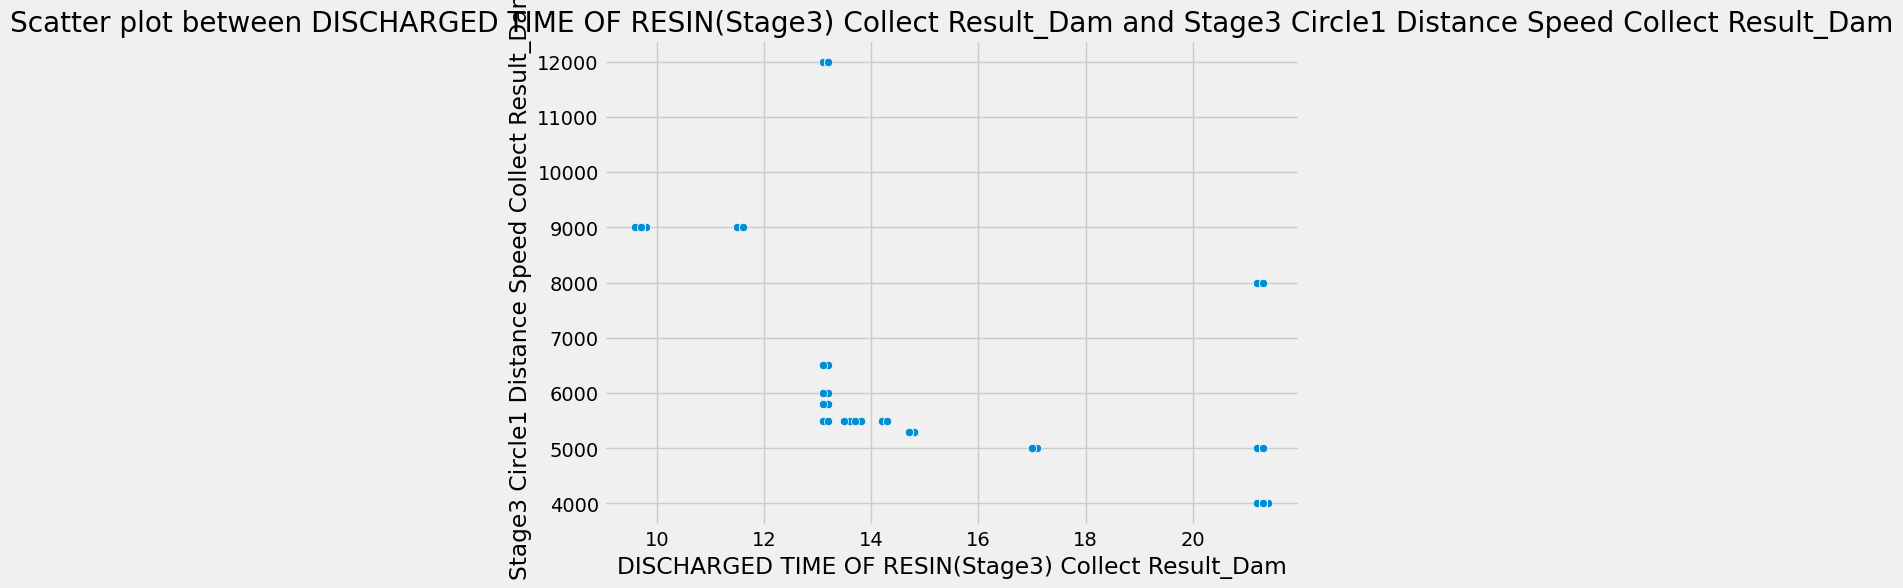

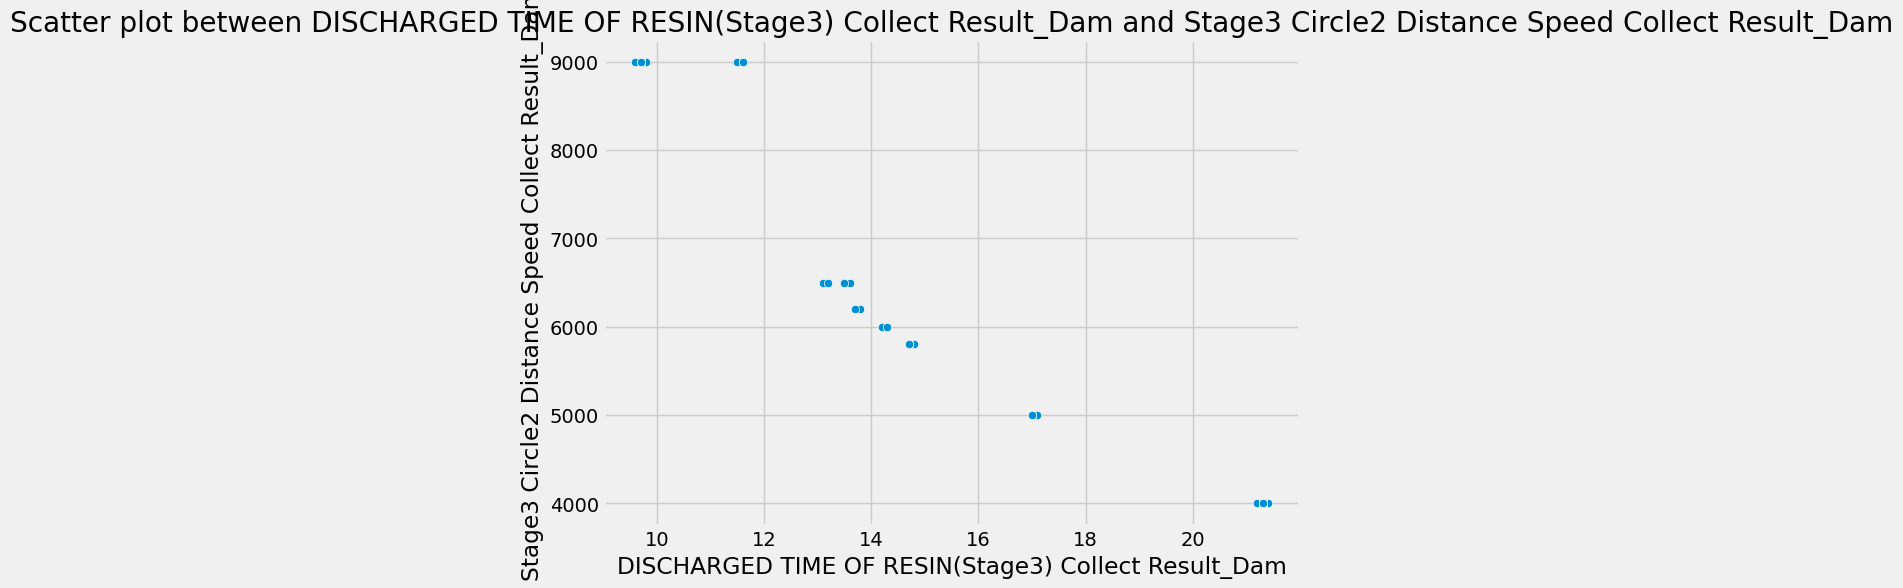

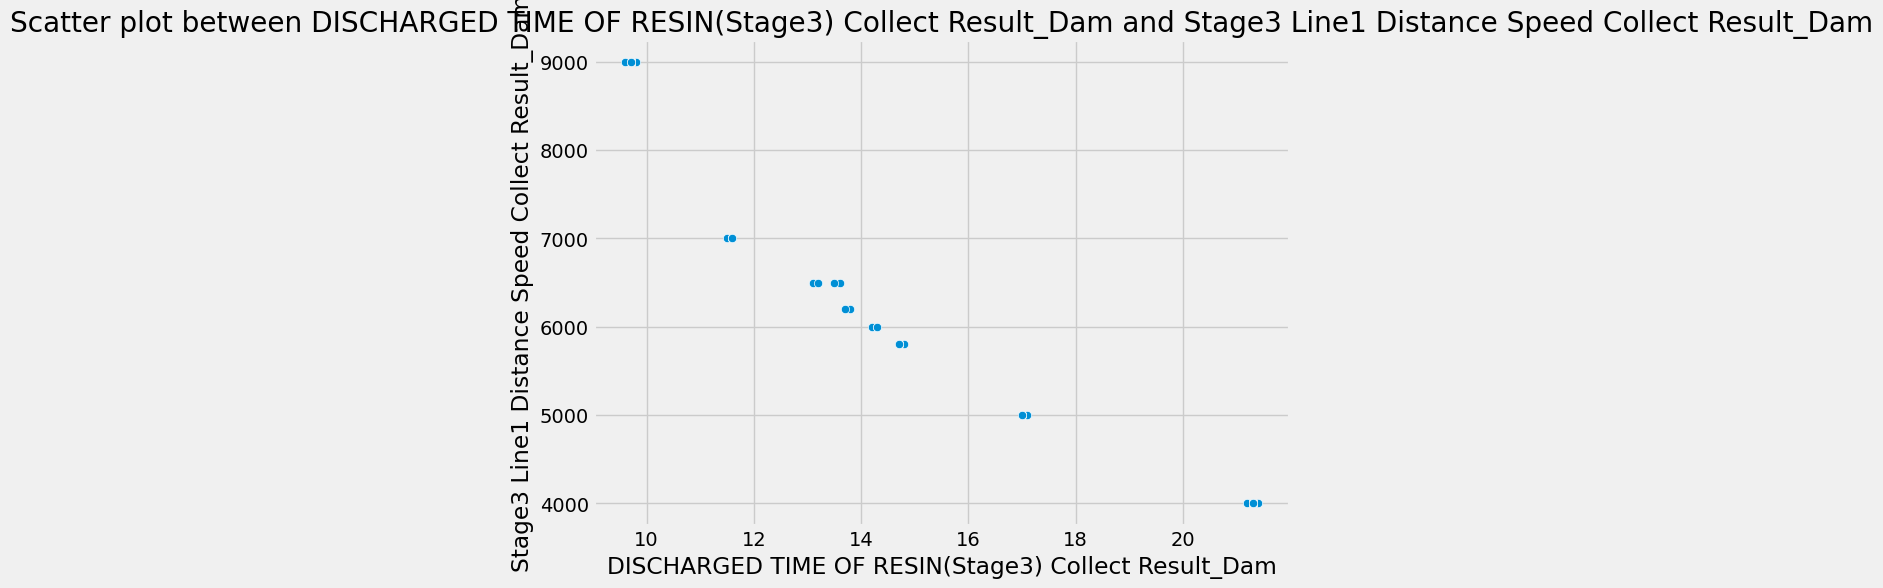

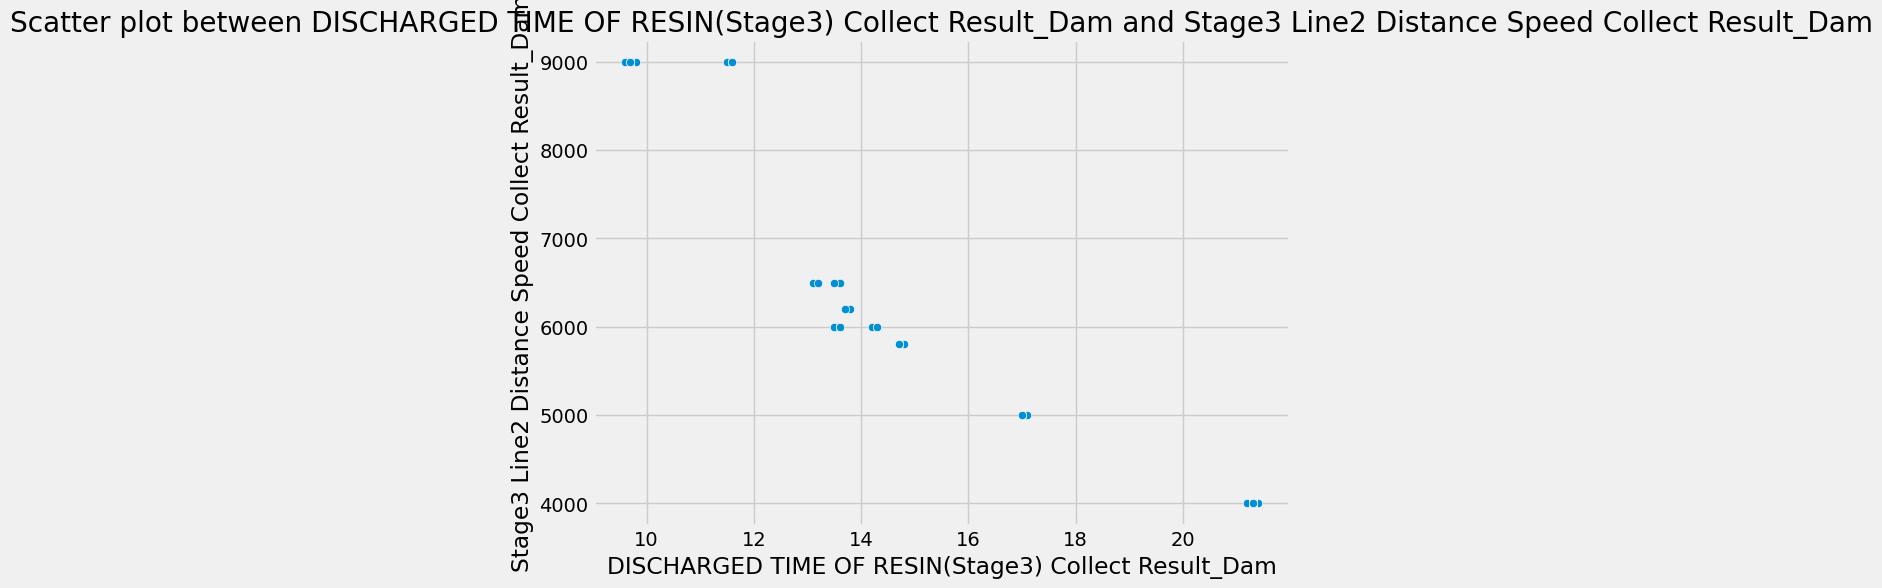

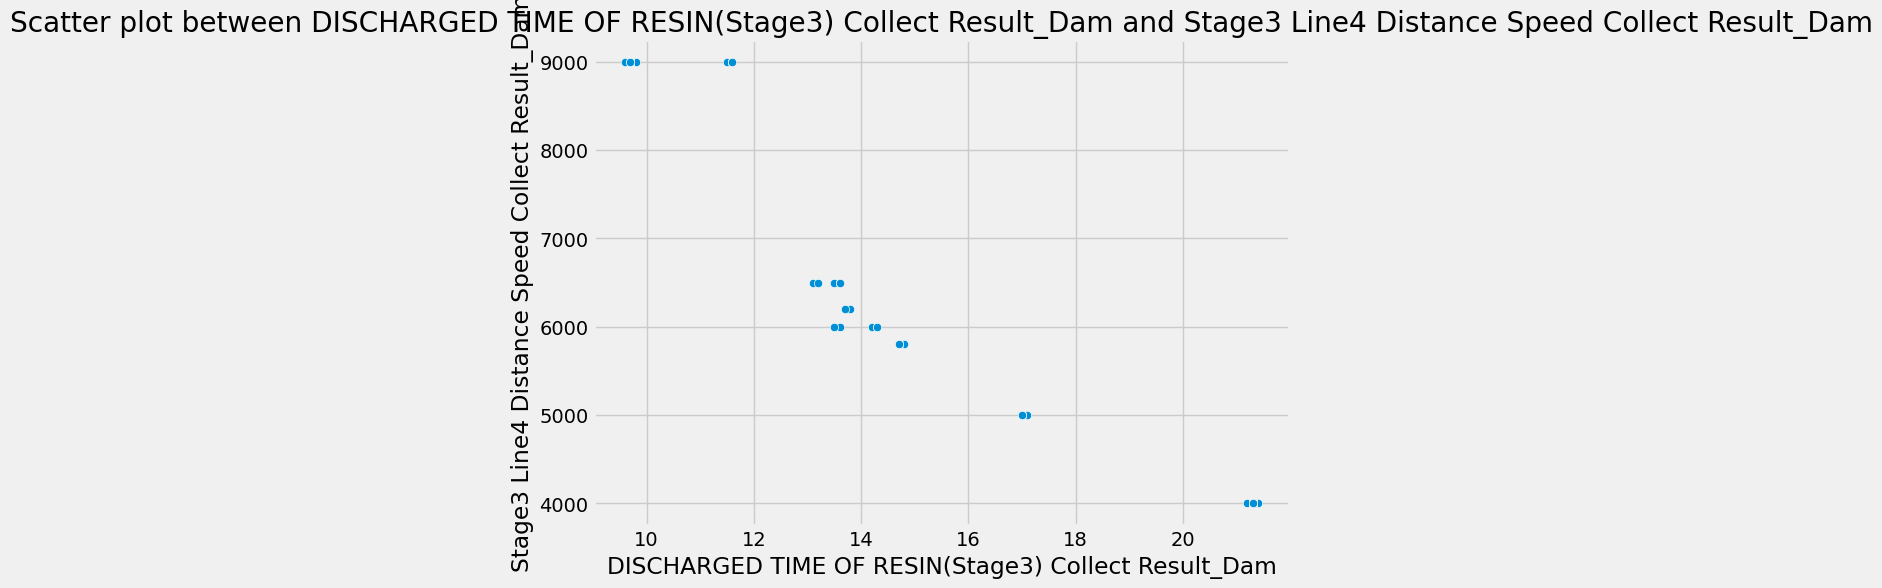

In [111]:
# 그룹 1과 그룹 2의 칼럼들 간의 산점도 그리기
for col1 in group1_columns:
    for col2 in group2_columns:
        plt.figure(figsize=(8, 6))
        sns.scatterplot(data=train_data, x=col1, y=col2)
        plt.title(f'Scatter plot between {col1} and {col2}')
        plt.xlabel(col1)
        plt.ylabel(col2)
        plt.show()

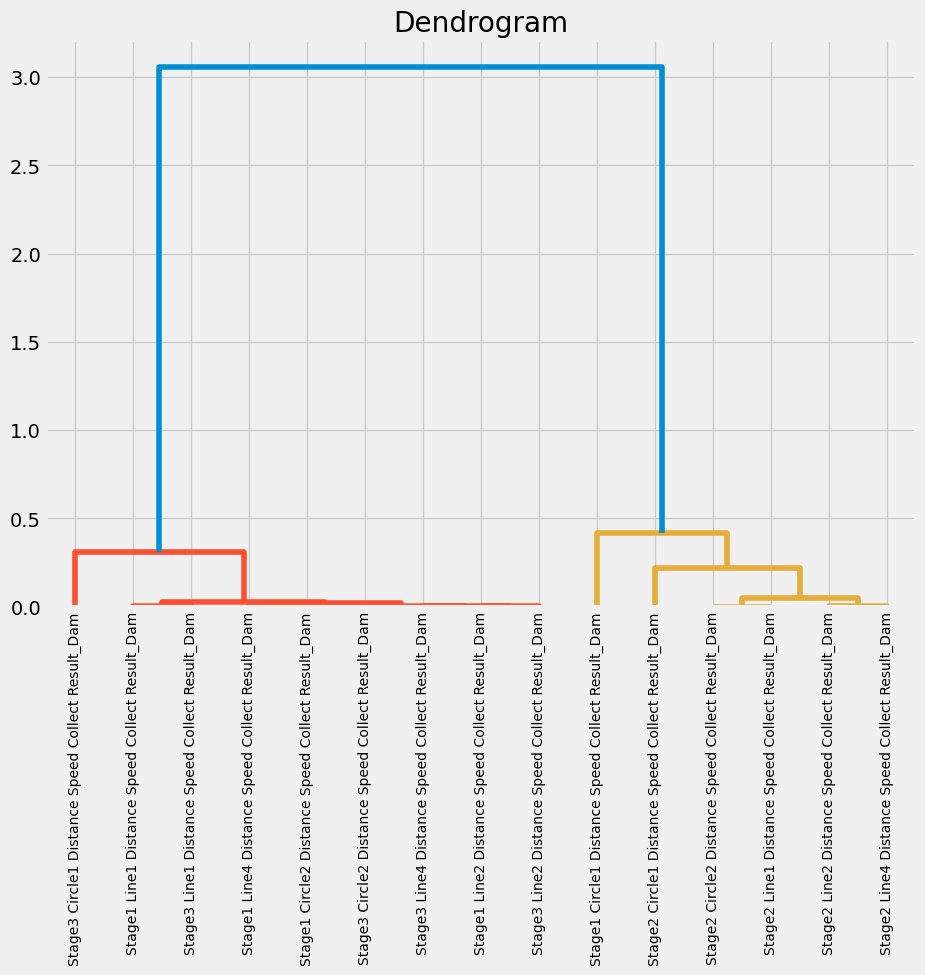

In [112]:
# 예시: 상관계수 행렬 계산
correlation_matrix = train_data[group2_columns].corr().values

# 계층적 클러스터링을 위한 linkage 계산
linkage_matrix = sch.linkage(1 - correlation_matrix, method='ward')

# 덴드로그램 그리기
plt.figure(figsize=(10, 7))
dendrogram = sch.dendrogram(linkage_matrix, labels=group2_columns, leaf_rotation=90, leaf_font_size=10)
plt.title("Dendrogram")
plt.show()

In [113]:
from scipy.cluster.hierarchy import fcluster

In [114]:
# 임계값에 따라 클러스터를 생성합니다.
threshold = 0.3 
clusters = fcluster(linkage_matrix, threshold, criterion='distance')

# 클러스터 결과 출력
clustered_variables = pd.DataFrame({'Variable': group2_columns, 'Cluster': clusters})
print(clustered_variables)

                                            Variable  Cluster
0   Stage1 Circle1 Distance Speed Collect Result_Dam        4
1   Stage1 Circle2 Distance Speed Collect Result_Dam        1
2     Stage1 Line1 Distance Speed Collect Result_Dam        1
3     Stage1 Line2 Distance Speed Collect Result_Dam        1
4     Stage1 Line4 Distance Speed Collect Result_Dam        1
5   Stage2 Circle1 Distance Speed Collect Result_Dam        3
6   Stage2 Circle2 Distance Speed Collect Result_Dam        3
7     Stage2 Line1 Distance Speed Collect Result_Dam        3
8     Stage2 Line2 Distance Speed Collect Result_Dam        3
9     Stage2 Line4 Distance Speed Collect Result_Dam        3
10  Stage3 Circle1 Distance Speed Collect Result_Dam        2
11  Stage3 Circle2 Distance Speed Collect Result_Dam        1
12    Stage3 Line1 Distance Speed Collect Result_Dam        1
13    Stage3 Line2 Distance Speed Collect Result_Dam        1
14    Stage3 Line4 Distance Speed Collect Result_Dam        1


In [115]:
# 각 클러스터에서 대표 변수 선택 (예: 각 클러스터에서 첫 번째 변수 선택)
representative_vars = clustered_variables.groupby('Cluster').first()['Variable'].values
print("Representative Variables for each cluster:")
print(representative_vars)

Representative Variables for each cluster:
['Stage1 Circle2 Distance Speed Collect Result_Dam'
 'Stage3 Circle1 Distance Speed Collect Result_Dam'
 'Stage2 Circle1 Distance Speed Collect Result_Dam'
 'Stage1 Circle1 Distance Speed Collect Result_Dam']


### 파생변수 추가

In [116]:
stage1 = ['Stage1 Circle2 Distance Speed Collect Result_Dam',
    'Stage1 Line1 Distance Speed Collect Result_Dam',
    'Stage1 Line2 Distance Speed Collect Result_Dam',
    'Stage1 Line4 Distance Speed Collect Result_Dam']

stage3 = ['Stage3 Circle2 Distance Speed Collect Result_Dam',
    'Stage3 Line1 Distance Speed Collect Result_Dam',
    'Stage3 Line2 Distance Speed Collect Result_Dam',
    'Stage3 Line4 Distance Speed Collect Result_Dam']

In [117]:
train_data, pca_result_stage1 = apply_pca(train_data, stage1, 1, prefix='stage1_')
train_data, pca_result_stage3 = apply_pca(train_data, stage3, 1, prefix='stage3_')

In [118]:
stage2 = ['Stage2 Circle1 Distance Speed Collect Result_Dam',
    'Stage2 Circle2 Distance Speed Collect Result_Dam',
    'Stage2 Line1 Distance Speed Collect Result_Dam',
    'Stage2 Line2 Distance Speed Collect Result_Dam',
    'Stage2 Line4 Distance Speed Collect Result_Dam']

In [119]:
train_data, pca_result_stage2 = apply_pca(train_data, stage2, 1, prefix='stage2_')

In [120]:
train_data

Model.Suffix_Dam Workorder_Dam  CURE END POSITION Θ Collect Result_Dam  \
0          AJX75334505    4F1XA938-1                                     -90   
1          AJX75334505    3KPM0016-2                                     -90   
2          AJX75334501    4E1X9167-1                                      90   
3          AJX75334501    3K1X0057-1                                      90   
4          AJX75334501    3HPM0007-1                                     -90   
...                ...           ...                                     ...   
40501      AJX75334501    3J1XF434-2                                     -90   
40502      AJX75334501    4E1XC796-1                                      90   
40503      AJX75334501    4C1XD438-1                                     -90   
40504      AJX75334501    3I1XA258-1                                      90   
40505      AJX75334501    3G1XA501-1                                     -90   

       CURE SPEED Collect Result_Dam  \
0                                100   
1                                 70   
2                                 85   
3                                 70   
4                                 70   
...                              ...   
40501                             70   
40502                            100   
40503                            100   
40504                             70   
40505                             70   

       CURE START POSITION Θ Collect Result_Dam  \
0                                           -90   
1                                           -90   
2                                            90   
3                                            90   
4                                           -90   
...                                         ...   
40501                                       -90   
40502                                        90   
40503                                       -90   
40504                                        90   
40505                                       -90   

       DISCHARGED SPEED OF RESIN Collect Result_Dam  \
0                                                16   
1                                                10   
2                                                16   
3                                                10   
4                                                10   
...                                             ...   
40501                                            10   
40502                                            16   
40503                                            16   
40504                                            10   
40505                                            10   

       DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam  \
0                                                   14.9     
1                                                   21.3     
2                                                   14.7     
3                                                   21.3     
4                                                    9.7     
...                                                  ...     
40501                                               17.0     
40502                                               14.9     
40503                                               14.2     
40504                                                9.7     
40505                                                9.6     

       DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam  \
0                                                    8.4     
1                                                    4.9     
2                                                    8.5     
3                                                    8.4     
4                                                    4.9     
...                                                  ...     
40501                                                5.0     
40502                                            

## CatBoost

### 데이터 분할


In [126]:
X = train_data.drop('target',axis=1)
y = train_data['target']

x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

### 하이퍼파라미터

#### cat_features

In [127]:
# object형 변수는 cat_features에 추가
cat_features = [f for f in X.columns if X[f].dtype == 'object']

def column_index(df, cat_features):
    cols = df.columns.values
    sidx = np.argsort(cols)
    return sidx[np.searchsorted(cols, cat_features, sorter=sidx)]

cat_features_idx = column_index(train_data, cat_features)    
print("Cat features are: %s \n" % [f for f in cat_features])
print(cat_features_idx)

Cat features are: ['Model.Suffix_Dam', 'Workorder_Dam', 'WorkMode Collect Result_Dam', 'WorkMode Collect Result_Fill2'] 

[ 0  1 17 41]


In [128]:
# NaN 값을 문자열로 변환
for col in cat_features:
    x_train[col] = x_train[col].astype(str).fillna('missing')  # NaN을 'missing'으로 대체
    x_val[col] = x_val[col].astype(str).fillna('missing')      # NaN을 'missing'으로 대체

#### class_weight

In [129]:
# 불균형한 클래스인 것으로 확인되어 class_weight = 'balanced'로 설정
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

display(class_weights)

{'AbNormal': 8.641066666666667, 'Normal': 0.5307085066657932}

#### optuna

In [130]:
# Objective 함수
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 700, 1500),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.3),
        "depth": trial.suggest_int("depth", 5, 10),
        "subsample": trial.suggest_loguniform("subsample", 0.5, 0.8),
        "random_state": 42,
        "class_weights" : class_weights,
        "cat_features" : cat_features,
        'eval_metric' : 'F1',
        "verbose": 1

    }

    cat_model = CatBoostClassifier(**params)

    cat_model.fit(x_train, y_train)
    val_pred = cat_model.predict(x_val)

    return f1_score(y_val, val_pred, pos_label='AbNormal')

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

best_params = study.best_params
print("Best params:", best_params)

[I 2024-08-18 00:39:12,229] A new study created in memory with name: no-name-a35db135-b531-4c59-ba2f-fcee4740e1e1


0:	learn: 0.5262657	total: 44.3ms	remaining: 44.1s
1:	learn: 0.5843699	total: 76.5ms	remaining: 38.1s
2:	learn: 0.5933003	total: 105ms	remaining: 34.7s
3:	learn: 0.5915810	total: 132ms	remaining: 32.7s
4:	learn: 0.6086509	total: 157ms	remaining: 31.1s
5:	learn: 0.6146357	total: 183ms	remaining: 30.3s
6:	learn: 0.6246572	total: 207ms	remaining: 29.3s
7:	learn: 0.6257805	total: 232ms	remaining: 28.7s
8:	learn: 0.6261049	total: 261ms	remaining: 28.7s
9:	learn: 0.6247804	total: 286ms	remaining: 28.3s
10:	learn: 0.6223459	total: 314ms	remaining: 28.1s
11:	learn: 0.6155289	total: 338ms	remaining: 27.7s
12:	learn: 0.6216114	total: 366ms	remaining: 27.7s
13:	learn: 0.6176747	total: 391ms	remaining: 27.5s
14:	learn: 0.6157351	total: 413ms	remaining: 27.1s
15:	learn: 0.6133407	total: 441ms	remaining: 27.1s
16:	learn: 0.6134534	total: 467ms	remaining: 26.9s
17:	learn: 0.6134852	total: 490ms	remaining: 26.6s
18:	learn: 0.6134262	total: 513ms	remaining: 26.4s
19:	learn: 0.6178575	total: 541ms	remai

169:	learn: 0.6229156	total: 3.86s	remaining: 18.8s
170:	learn: 0.6232998	total: 3.88s	remaining: 18.7s
171:	learn: 0.6232998	total: 3.89s	remaining: 18.7s
172:	learn: 0.6230564	total: 3.9s	remaining: 18.6s
173:	learn: 0.6234851	total: 3.92s	remaining: 18.5s
174:	learn: 0.6235072	total: 3.94s	remaining: 18.5s
175:	learn: 0.6236316	total: 3.95s	remaining: 18.4s
176:	learn: 0.6240073	total: 3.96s	remaining: 18.4s
177:	learn: 0.6242811	total: 3.98s	remaining: 18.3s
178:	learn: 0.6246125	total: 4s	remaining: 18.3s
179:	learn: 0.6245020	total: 4.01s	remaining: 18.2s
180:	learn: 0.6248112	total: 4.03s	remaining: 18.2s
181:	learn: 0.6243474	total: 4.04s	remaining: 18.1s
182:	learn: 0.6245241	total: 4.05s	remaining: 18s
183:	learn: 0.6248642	total: 4.07s	remaining: 18s
184:	learn: 0.6250099	total: 4.08s	remaining: 17.9s
185:	learn: 0.6247979	total: 4.09s	remaining: 17.8s
186:	learn: 0.6245549	total: 4.11s	remaining: 17.8s
187:	learn: 0.6243253	total: 4.12s	remaining: 17.7s
188:	learn: 0.624104

334:	learn: 0.6322781	total: 6.35s	remaining: 12.6s
335:	learn: 0.6322563	total: 6.37s	remaining: 12.5s
336:	learn: 0.6325300	total: 6.38s	remaining: 12.5s
337:	learn: 0.6322666	total: 6.4s	remaining: 12.5s
338:	learn: 0.6325955	total: 6.42s	remaining: 12.5s
339:	learn: 0.6322666	total: 6.43s	remaining: 12.4s
340:	learn: 0.6320036	total: 6.45s	remaining: 12.4s
341:	learn: 0.6325941	total: 6.46s	remaining: 12.4s
342:	learn: 0.6325941	total: 6.48s	remaining: 12.4s
343:	learn: 0.6326043	total: 6.49s	remaining: 12.3s
344:	learn: 0.6329868	total: 6.51s	remaining: 12.3s
345:	learn: 0.6329986	total: 6.53s	remaining: 12.3s
346:	learn: 0.6332167	total: 6.54s	remaining: 12.3s
347:	learn: 0.6329096	total: 6.56s	remaining: 12.2s
348:	learn: 0.6328660	total: 6.57s	remaining: 12.2s
349:	learn: 0.6334249	total: 6.59s	remaining: 12.2s
350:	learn: 0.6331395	total: 6.6s	remaining: 12.2s
351:	learn: 0.6333040	total: 6.62s	remaining: 12.1s
352:	learn: 0.6331613	total: 6.63s	remaining: 12.1s
353:	learn: 0.

493:	learn: 0.6382642	total: 8.83s	remaining: 8.99s
494:	learn: 0.6382209	total: 8.84s	remaining: 8.97s
495:	learn: 0.6382209	total: 8.86s	remaining: 8.95s
496:	learn: 0.6380339	total: 8.88s	remaining: 8.93s
497:	learn: 0.6380339	total: 8.89s	remaining: 8.91s
498:	learn: 0.6380556	total: 8.91s	remaining: 8.89s
499:	learn: 0.6380772	total: 8.92s	remaining: 8.87s
500:	learn: 0.6379689	total: 8.94s	remaining: 8.85s
501:	learn: 0.6380556	total: 8.95s	remaining: 8.82s
502:	learn: 0.6383942	total: 8.96s	remaining: 8.8s
503:	learn: 0.6384513	total: 8.98s	remaining: 8.79s
504:	learn: 0.6388040	total: 9s	remaining: 8.76s
505:	learn: 0.6386818	total: 9.01s	remaining: 8.74s
506:	learn: 0.6385596	total: 9.03s	remaining: 8.72s
507:	learn: 0.6384946	total: 9.04s	remaining: 8.7s
508:	learn: 0.6385951	total: 9.06s	remaining: 8.68s
509:	learn: 0.6382642	total: 9.07s	remaining: 8.66s
510:	learn: 0.6383429	total: 9.09s	remaining: 8.64s
511:	learn: 0.6381775	total: 9.1s	remaining: 8.62s
512:	learn: 0.6382

[W 2024-08-18 00:39:23,828] Trial 0 failed with parameters: {'n_estimators': 997, 'learning_rate': 0.004976340444275557, 'depth': 5, 'subsample': 0.735961094315445} because of the following error: KeyboardInterrupt('').
Traceback (most recent call last):
  File "/home/elicer/.local/lib/python3.10/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_55/1971998281.py", line 18, in objective
    cat_model.fit(x_train, y_train)
  File "/home/elicer/.local/lib/python3.10/site-packages/catboost/core.py", line 5220, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/home/elicer/.local/lib/python3.10/site-packages/catboost/core.py", line 2400, in _fit
    self._train(
  File "/home/elicer/.local/lib/python3.10/site-packages/catboost/core.py", line 1780, in _train
    self._object._train(train_pool, test_pool, params, allo

650:	learn: 0.6423169	total: 11.3s	remaining: 6.01s
651:	learn: 0.6424612	total: 11.3s	remaining: 6s
652:	learn: 0.6424612	total: 11.3s	remaining: 5.98s


KeyboardInterrupt: 

In [91]:
cat_params = {'n_estimators': 916, 'learning_rate': 0.024808413878868583, 'depth': 9, 'subsample': 0.7100374608182494}
cat_model = CatBoostClassifier(**cat_params, cat_features=cat_features, class_weights=class_weights, verbose=100)

cat_model.fit(x_train, y_train)

train_pred = cat_model.predict(x_train)
val_pred = cat_model.predict(x_val)

print(f1_score(y_train, train_pred, pos_label='AbNormal'), f1_score(y_val, val_pred, pos_label='AbNormal'))
print(f1_score(y_train, train_pred, pos_label='Normal'), f1_score(y_val, val_pred, pos_label='Normal'))

0:	learn: 0.6908185	total: 86.4ms	remaining: 1m 19s
100:	learn: 0.6050841	total: 5.01s	remaining: 40.4s
200:	learn: 0.5663249	total: 8.92s	remaining: 31.7s
300:	learn: 0.5323816	total: 12.8s	remaining: 26.2s
400:	learn: 0.4990306	total: 16.9s	remaining: 21.7s
500:	learn: 0.4499792	total: 21.2s	remaining: 17.5s
600:	learn: 0.3990624	total: 25.6s	remaining: 13.4s
700:	learn: 0.3577639	total: 29.9s	remaining: 9.18s
800:	learn: 0.3239147	total: 34.4s	remaining: 4.93s
900:	learn: 0.2949399	total: 38.8s	remaining: 645ms
915:	learn: 0.2909258	total: 39.4s	remaining: 0us
0.545234388514098 0.2112567463377024
0.9554610601927931 0.9313745220366272


### predictions

In [122]:
test_data = pd.read_csv(os.path.join(ROOT_DIR, "test.csv"))

In [123]:
test_data = preprocess_data(test_data)

In [124]:
def apply_pca_to_test(test_df, pca, filtered_coordinate_cols, prefix):
    # PCA에 사용할 데이터셋 추출
    pca_input_data = test_df[filtered_coordinate_cols]

    # PCA 변환 수행 (이미 학습된 PCA를 사용)
    pca_result = pca.transform(pca_input_data)

    # PCA 결과를 데이터프레임으로 저장
    pca_df = pd.DataFrame(data=pca_result, columns=[f'{prefix}{i+1}' for i in range(pca.n_components_)])

    # PCA에 사용된 좌표 피처 제거
    test_df = test_df.drop(columns=filtered_coordinate_cols)

    # PCA 결과 (주성분) 추가
    for i in range(pca.n_components_):
        test_df[f'{prefix}{i+1}'] = pca_df[f'{prefix}{i+1}']

    return test_df

In [125]:
test_data = apply_pca_to_test(test_data, pca_result_PC, filtered_cols, 'PC')

In [132]:
test_data

Set ID Model.Suffix_Dam Workorder_Dam  \
0      0001be084fbc4aaa9d921f39e595961b      AJX75334501    3J1XF767-1   
1      0005bbd180064abd99e63f9ed3e1ac80      AJX75334501    4B1XD472-2   
2      000948934c4140d883d670adcb609584      AJX75334501    3H1XE355-1   
3      000a6bfd02874c6296dc7b2e9c5678a7      AJX75334501    3L1XA128-1   
4      0018e78ce91343678716e2ea27a51c95      AJX75334501    4A1XA639-1   
...                                 ...              ...           ...   
17356  ffea508b59934d689b540f95eb3fa730      AJX75334501    3K1XB597-1   
17357  ffed8923c8a448a98afc641b770be153      AJX75334501    4A1XB974-1   
17358  fff1e73734da40adbe805359b3efb462      AJX75334501    3L1XA998-1   
17359  fff8e38bdd09470baf95f71e92075dec      AJX75334501    3F1XC376-1   
17360  fffa83e0a13d4c2db4fd8bf905b517d4      AJX75334501    3J1XC756-1   

       CURE END POSITION X Collect Result_Dam  \
0                                      1000.0   
1                                      1000.0   
2                                       240.0   
3                                      1000.0   
4                                       240.0   
...                                       ...   
17356                                  1000.0   
17357                                  1000.0   
17358                                   240.0   
17359                                   240.0   
17360                                   240.0   

       CURE END POSITION Z Collect Result_Dam  \
0                                        12.5   
1                                        12.5   
2                                         2.5   
3                                        12.5   
4                                         2.5   
...                                       ...   
17356                                    12.5   
17357                                    12.5   
17358                                     2.5   
17359                                     2.5   
17360                                     2.5   

       CURE END POSITION Θ Collect Result_Dam  CURE SPEED Collect Result_Dam  \
0                                          90                             70   
1                                          90                             70   
2                                         -90                             70   
3                                          90                             70   
4                                         -90                             70   
...                                       ...                            ...   
17356                                      90                             70   
17357                                      90                             70   
17358                                     -90                             70   
17359                                     -90                             70   
17360                                     -90                             70   

       CURE START POSITION X Collect Result_Dam  \
0                                           280   
1                                           280   
2                                          1030   
3                                           280   
4                                          1030   
...                                         ...   
17356                                       280   
17357                                       280   
17358                                      1030   
17359                                      1030   
17360                                      1030   

       CURE START POSITION Θ Collect Result_Dam  \
0                                            90   
1                                            90   
2                                           -90   
3                                            90   
4                                           -90   
...                                         ...   
17356                              

In [133]:
test_data = apply_pca_to_test(test_data, pca_result_corr_PC, all_columns, 'corr_PC')
test_data = apply_pca_to_test(test_data, pca_result_stage1, stage1, 'stage1_')
test_data = apply_pca_to_test(test_data, pca_result_stage3, stage3, 'stage3_')
test_data = apply_pca_to_test(test_data, pca_result_stage2, stage2, 'stage2_')

In [136]:
# Set ID 열 제거
test_data = test_data.drop(columns=['Set ID'], errors='ignore')
test_data

Model.Suffix_Dam Workorder_Dam  CURE END POSITION Θ Collect Result_Dam  \
0          AJX75334501    3J1XF767-1                                      90   
1          AJX75334501    4B1XD472-2                                      90   
2          AJX75334501    3H1XE355-1                                     -90   
3          AJX75334501    3L1XA128-1                                      90   
4          AJX75334501    4A1XA639-1                                     -90   
...                ...           ...                                     ...   
17356      AJX75334501    3K1XB597-1                                      90   
17357      AJX75334501    4A1XB974-1                                      90   
17358      AJX75334501    3L1XA998-1                                     -90   
17359      AJX75334501    3F1XC376-1                                     -90   
17360      AJX75334501    3J1XC756-1                                     -90   

       CURE SPEED Collect Result_Dam  \
0                                 70   
1                                 70   
2                                 70   
3                                 70   
4                                 70   
...                              ...   
17356                             70   
17357                             70   
17358                             70   
17359                             70   
17360                             70   

       CURE START POSITION Θ Collect Result_Dam  \
0                                            90   
1                                            90   
2                                           -90   
3                                            90   
4                                           -90   
...                                         ...   
17356                                        90   
17357                                        90   
17358                                       -90   
17359                                       -90   
17360                                       -90   

       DISCHARGED SPEED OF RESIN Collect Result_Dam  \
0                                                10   
1                                                16   
2                                                10   
3                                                10   
4                                                16   
...                                             ...   
17356                                            10   
17357                                            16   
17358                                            16   
17359                                            10   
17360                                            10   

       DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam  \
0                                                   17.0     
1                                                   14.2     
2                                                    9.7     
3                                                   21.3     
4                                                   13.2     
...                                                  ...     
17356                                               21.3     
17357                                               13.2     
17358                                               13.2     
17359                                                9.7     
17360                                               17.0     

       DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam  \
0                                                    4.9     
1                                                    8.3     
2                                                    4.9     
3                                                   10.6     
4                                                    7.5     
...                                                  ...     
17356                                               10.6     
17357                                            

In [137]:
# NaN 값을 문자열로 변환
for col in cat_features:
    test_data[col] = test_data[col].astype(str).fillna('missing')      # NaN을 'missing'으로 대체

In [138]:
test_pred = cat_model.predict(test_data)
test_pred

array(['AbNormal', 'Normal', 'Normal', ..., 'Normal', 'Normal', 'Normal'],
      dtype=object)

In [139]:
# 'AbNormal'의 개수 확인
abnormal_count = np.count_nonzero(test_pred == 'AbNormal')
print(f"'AbNormal'의 개수: {abnormal_count}")
19/len(test_pred)

'AbNormal'의 개수: 1894


0.001094407004204827

In [142]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["target"] = test_pred

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

0.197